In [1]:
import joblib

import json

import lightgbm as lgb

from matplotlib.patches import Patch

import matplotlib.pyplot as plt

import mlflow

import numpy as np

import os

import pandas as pd

import pickle

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (make_scorer, confusion_matrix, recall_score, precision_score, f1_score, 
roc_auc_score, accuracy_score, precision_recall_curve)

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler

import time

import traceback

import xgboost as xgb

# Définition des fonctions utiles 

In [2]:
def business_score(y_true, y_pred):
    """
    Score business personnalisé basé sur les coûts :
    - Coût rétention = 1x (baseline)
    - Coût acquisition = 5x 
    - Objectif : Maximiser le profit
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des coûts
    # TP : Client churn détecté → Action rétention → Coût 1x mais évite perte 5x → Gain net = +4x
    # FP : Client fidèle → Action inutile et client contacté pour rien (risque de lassitude)→ Coût 2.5x → Perte = -2.5x  
    # TN : Client fidèle bien classé → Pas d'action → Coût 0x
    # FN : Client churn raté → Perte client → Coût 5x → Perte = -5x
    
    profit = (tp * 4) - (fp * 2.5) - (fn * 5)
    total_clients = len(y_true)
    
    # Score normalisé (plus c'est élevé, mieux c'est)
    business_score_value = profit / total_clients
    
    return business_score_value

In [3]:
def optimize_threshold_for_business_score(y_true, y_pred_proba):
    """
    Trouve le seuil qui maximise le business score avec contrainte de recall à minimum 0.8
    """
    
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    precisions = precisions[:-1]
    recalls = recalls[:-1]
    
    best_business_score = -np.inf
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        bs = business_score(y_true, y_pred)
        
        # Calculer le recall pour ce seuil
        current_recall = recall_score(y_true, y_pred)
        
        # Appliquer la pénalité de recall
        penalized_score = bs * (current_recall /0.8)
        
        if penalized_score > best_business_score:
            best_business_score = penalized_score
            best_threshold = threshold
    
    return best_threshold


In [4]:
def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, 
                                      scaler=None, hyperparams=None, nested=False, cv_folds=3):
    """
    Version corrigée avec gestion proper des indices pandas
    """
    
    
    # Démarrer un run seulement si on n'est pas déjà dans un run
    if nested or mlflow.active_run():
        run_context = None
    else:
        run_context = mlflow.start_run(run_name=model_name)
    
    try:
        print(f"🔄 Entraînement {model_name} avec CV {cv_folds}-fold...")
        
        # Log des hyperparamètres
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_param("cv_folds", cv_folds)
        mlflow.log_param("optimization_target", "business_score")
        
        # Preprocessing si nécessaire
        if scaler:
            X_train_processed = scaler.fit_transform(X_train)
            X_test_processed = scaler.transform(X_test)
        else:
            X_train_processed = X_train.values if hasattr(X_train, 'values') else X_train
            X_test_processed = X_test.values if hasattr(X_test, 'values') else X_test
        
        # Convertir y en array pour éviter les problèmes d'indexing
        y_train_array = y_train.values if hasattr(y_train, 'values') else y_train
        y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
        
        # === CROSS-VALIDATION POUR VALIDATION ROBUSTESSE ===
        print("📊 Cross-validation en cours...")
        
        # Stratified K-Fold pour préserver les proportions de classes
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Métriques à évaluer en CV
        cv_scores = {
            'accuracy': [],
            'roc_auc': [],
            'recall': [],
            'precision': [],
            'f1': [],
            'business_score': [],
            'threshold': []  # AJOUT: stocker les seuils de chaque fold
        }
        
        # Cross-validation manuelle pour avoir accès aux prédictions
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_processed, y_train_array)):
            print(f"  Fold {fold + 1}/{cv_folds}...")
            
            # Split pour ce fold - CORRECTION DES INDICES
            X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
            y_fold_train, y_fold_val = y_train_array[train_idx], y_train_array[val_idx]
            
            # Entraîner le modèle sur ce fold
            try:
                # Créer une nouvelle instance du modèle
                if hasattr(model, 'get_params'):
                    model_fold = model.__class__(**model.get_params())
                else:
                    model_fold = model.__class__()
                
                model_fold.fit(X_fold_train, y_fold_train)
                
                # Prédictions
                y_pred_proba_fold = model_fold.predict_proba(X_fold_val)[:, 1]
                
                # Optimiser le seuil pour ce fold (business score)
                optimal_threshold_fold = optimize_threshold_for_business_score(y_fold_val, y_pred_proba_fold)
                y_pred_fold = (y_pred_proba_fold >= optimal_threshold_fold).astype(int)
                
                # Calculer les métriques pour ce fold
                
                cv_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred_fold))
                cv_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_pred_proba_fold))
                cv_scores['recall'].append(recall_score(y_fold_val, y_pred_fold))
                cv_scores['precision'].append(precision_score(y_fold_val, y_pred_fold))
                cv_scores['f1'].append(f1_score(y_fold_val, y_pred_fold))
                cv_scores['business_score'].append(business_score(y_fold_val, y_pred_fold))
                cv_scores['threshold'].append(optimal_threshold_fold)  # AJOUT
                
            except Exception as e:
                print(f"    ⚠️ Erreur fold {fold + 1}: {e}")
                # En cas d'erreur, on utilise des valeurs par défaut
                cv_scores['accuracy'].append(0.5)
                cv_scores['roc_auc'].append(0.5)
                cv_scores['recall'].append(0.5)
                cv_scores['precision'].append(0.3)
                cv_scores['f1'].append(0.3)
                cv_scores['business_score'].append(0.0)
                cv_scores['threshold'].append(0.5)
        
        # Calculer les moyennes et écarts-types de CV
        cv_results = {}
        for metric, scores in cv_scores.items():
            cv_results[f'cv_{metric}_mean'] = np.mean(scores)
            cv_results[f'cv_{metric}_std'] = np.std(scores)
            
            # Logger dans MLflow
            mlflow.log_metric(f"cv_{metric}_mean", np.mean(scores))
            mlflow.log_metric(f"cv_{metric}_std", np.std(scores))
        
        print(f"📊 Résultats CV:")
        print(f"  • Business Score: {cv_results['cv_business_score_mean']:.3f} ± {cv_results['cv_business_score_std']:.3f}")
        print(f"  • Recall: {cv_results['cv_recall_mean']:.3f} ± {cv_results['cv_recall_std']:.3f}")
        print(f"  • Seuil moyen CV: {cv_results['cv_threshold_mean']:.3f} ± {cv_results['cv_threshold_std']:.3f}")  # AJOUT
        print(f"  • AUC: {cv_results['cv_roc_auc_mean']:.3f} ± {cv_results['cv_roc_auc_std']:.3f}")
        
        # === ENTRAÎNEMENT FINAL SUR TOUT LE TRAINING SET ===
        print("🎯 Entraînement final sur dataset complet...")
        model.fit(X_train_processed, y_train_array)
        
        # Prédictions sur test set
        y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
        
        # === OPTIMISATION DU SEUIL POUR BUSINESS SCORE ===
        print("⚖️ Optimisation du seuil pour business score...")
        optimal_threshold = optimize_threshold_for_business_score(y_test_array, y_pred_proba)
        
        # AFFICHAGE DU SEUIL CHOISI
        print(f"🎯 SEUIL OPTIMAL TROUVÉ: {optimal_threshold:.4f}")
        if optimal_threshold < 0.1:
            print("⚠️  ATTENTION: Seuil très bas - beaucoup de prédictions positives")
        elif optimal_threshold < 0.3:
            print("🟡 Seuil assez bas - stratégie agressive")
        elif optimal_threshold > 0.7:
            print("🔴 Seuil élevé - stratégie conservatrice")
        else:
            print("✅ Seuil dans une plage raisonnable")
        
        # Prédictions finales avec seuil optimal
        y_pred_final = (y_pred_proba >= optimal_threshold).astype(int)
        
        # === CALCUL DES MÉTRIQUES FINALES ===
        f1 = f1_score(y_test_array, y_pred_final)
        auc = roc_auc_score(y_test_array, y_pred_proba)
        accuracy = accuracy_score(y_test_array, y_pred_final)
        business_score_value = business_score(y_test_array, y_pred_final)
        
        optimal_recall = recall_score(y_test_array, y_pred_final)
        optimal_precision = precision_score(y_test_array, y_pred_final)
        
        # Matrice de confusion
        cm = confusion_matrix(y_test_array, y_pred_final)
        tn, fp, fn, tp = cm.ravel()
        
        # ANALYSE DU SEUIL
        print(f"📊 ANALYSE DU SEUIL {optimal_threshold:.4f}:")
        print(f"  • {np.sum(y_pred_proba >= optimal_threshold)} clients prédits churn ({np.sum(y_pred_proba >= optimal_threshold)/len(y_pred_proba):.1%})")
        print(f"  • {np.sum(y_pred_proba < optimal_threshold)} clients prédits fidèles ({np.sum(y_pred_proba < optimal_threshold)/len(y_pred_proba):.1%})")
        
        # === LOGGING MLFLOW ===
        # Métriques finales
        mlflow.log_metric("recall", optimal_recall)
        mlflow.log_metric("precision", optimal_precision)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("business_score", business_score_value)
        mlflow.log_metric("optimal_threshold", optimal_threshold)
        
        # Métriques de confusion
        mlflow.log_metric("true_positives", int(tp))
        mlflow.log_metric("true_negatives", int(tn))
        mlflow.log_metric("false_positives", int(fp))
        mlflow.log_metric("false_negatives", int(fn))
        mlflow.log_metric("clients_churn_rates", int(fn))
        
        # Calcul du profit business
        profit_total = (tp * 4) - (fp * 1) - (fn * 5)
        mlflow.log_metric("profit_total", float(profit_total))
        mlflow.log_metric("profit_per_client", float(profit_total / len(y_test_array)))
        
        # Métriques de stabilité CV
        mlflow.log_metric("cv_stability_business", cv_results['cv_business_score_std'])
        mlflow.log_metric("cv_stability_threshold", cv_results['cv_threshold_std'])  # AJOUT
        
        # Log du modèle seulement si on a créé un nouveau run
        if run_context:
            if model_name == "Logistic_Regression":
                mlflow.sklearn.log_model(model, "model")
            elif "XGBoost" in model_name:
                mlflow.xgboost.log_model(model, "model")
            elif model_name == "LightGBM":
                mlflow.lightgbm.log_model(model, "model")
            
            # Log des artefacts
            if scaler:
                joblib.dump(scaler, "scaler.pkl")
                mlflow.log_artifact("scaler.pkl")
        
        print(f"✅ {model_name} - Recall: {optimal_recall:.3f} | Precision: {optimal_precision:.3f} | Business Score: {business_score_value:.3f}")
        print(f"   CV Business Score: {cv_results['cv_business_score_mean']:.3f} ± {cv_results['cv_business_score_std']:.3f}")
        print(f"   Seuil final: {optimal_threshold:.4f}")
        
        return {
            'model': model,
            'scaler': scaler,
            'threshold': optimal_threshold,
            'recall': optimal_recall,
            'precision': optimal_precision,
            'business_score': business_score_value,
            'profit_total': profit_total,
            'clients_rates': int(fn),
            'cv_results': cv_results,
            'cv_stability': cv_results['cv_business_score_std'],
            'threshold_stability': cv_results['cv_threshold_std']  # AJOUT
        }
        
    except Exception as e:
        print(f"❌ Erreur lors de l'entraînement {model_name}: {e}")
        traceback.print_exc()
        return None
    
    finally:
        # Fermer le run seulement si on l'a créé
        if run_context:
            mlflow.end_run()



In [5]:
def create_business_scorer_with_fixed_threshold(fixed_threshold):
    """
    Crée un scorer qui utilise un seuil fixe (pas d'optimisation)
    """
    def business_scorer_fixed_threshold(estimator, X, y):
        # Obtenir les probabilités
        y_pred_proba = estimator.predict_proba(X)[:, 1]
        
        # Utiliser le seuil fixe (pas d'optimisation)
        y_pred_fixed = (y_pred_proba >= fixed_threshold).astype(int)
        
        # Calculer le business score
        bs = business_score(y, y_pred_fixed)
        
        # Appliquer la contrainte de recall
        current_recall = recall_score(y, y_pred_fixed)
        penalized_score = bs * (current_recall / 0.8)
        
        return penalized_score
    
    return business_scorer_fixed_threshold

In [6]:
def optimize_xgboost_with_mlflow(X_train, y_train, reference_threshold, param_search_type='random'):
    """
    Optimise XGBoost avec un seuil de référence fixe
    """
    
    # Configuration cross-validation
    cv_folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
    # Modèle de base
    base_xgb = xgb.XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        eval_metric='logloss',
        verbose=0
    )
    
    # ← MODIFICATION : Scorer avec seuil fixe
    fixed_threshold_scorer = create_business_scorer_with_fixed_threshold(reference_threshold)
    
    with mlflow.start_run(run_name="XGBoost_Hyperparameter_Tuning"):
        
        # Log des paramètres de recherche
        mlflow.log_param("search_type", param_search_type)
        mlflow.log_param("cv_folds", 7)
        mlflow.log_param("reference_threshold", reference_threshold)  # ← AJOUT
        mlflow.log_param("scoring", "business_score_with_fixed_threshold")
        
        # RandomizedSearchCV avec le scorer à seuil fixe
        search = RandomizedSearchCV(
            estimator=base_xgb,
            param_distributions=param_distributions,
            n_iter=1000,
            cv=cv_folds,
            scoring=fixed_threshold_scorer,  # ← MODIFICATION
            n_jobs=-1,
            verbose=1,
            random_state=42
        )
        mlflow.log_param("n_iter", 1000)
        
        # Lancement de la recherche
        print(f"🔄 Recherche avec seuil fixe {reference_threshold:.4f}...")
        start_time = time.time()
        
        search.fit(X_train, y_train)
        
        search_time = time.time() - start_time
        
        # Log des résultats
        mlflow.log_param("search_time_seconds", search_time)
        mlflow.log_param("best_cv_score", search.best_score_)
        mlflow.log_params(search.best_params_)
        
        best_xgb = search.best_estimator_
        mlflow.xgboost.log_model(best_xgb, "optimized_model")
        
        print(f"✅ Recherche terminée en {search_time:.2f} secondes")
        print(f"🏆 Meilleur score CV: {search.best_score_:.4f}")
        print(f"🎯 Meilleurs paramètres: {search.best_params_}")
        
        return best_xgb, search.best_params_, search.best_score_


In [7]:
def convert_numpy_types(obj):
    """Convertit les types NumPy en types Python pour JSON"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj


# Import et création du dataframe

In [8]:
path = r'D:\projet_gael_pennessot\churn\WA_Fn-UseC_-Telco-Customer-Churn.xls'

In [9]:
DF = pd.read_csv(path)

In [10]:
DF.shape
print(f"Le Dataframe contient {DF.shape[0]} lignes et {DF.shape[1]} colonnes")

Le Dataframe contient 7043 lignes et 21 colonnes


In [11]:
DF.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# EDA

In [12]:
DF.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


On constate que le Dataframe est entiérement rempli, aucune valeurs non reseignées ne s'y trouvent

Nos features sont composées de 3 colonnes int et float, le reste est de type object. Il faudra penser à les encodées pour certains modéles

Apparemment la colonne TotalCharges est de type object alors qu'elle doit répertoriée l'ensemble des factures du client

In [14]:
for col in ['TotalCharges']:    
    try:
        pd.to_numeric(DF[col], errors='raise')
        print(f"✅ {col} peut être convertie en numérique")
    except:
        print(f"⚠️ {col} contient des valeurs non numériques")
        # Voir quelles valeurs posent problème
        non_numeric = DF[~pd.to_numeric(DF[col], errors='coerce').notna()][col].unique()
        print(f"Valeurs problématiques: {non_numeric}")

⚠️ TotalCharges contient des valeurs non numériques
Valeurs problématiques: [' ']


In [15]:
print("=== NETTOYAGE DE TotalCharges ===")
print(f"Nombre de valeurs avec espaces: {(DF['TotalCharges'] == ' ').sum()}")

# Remplacer les espaces par 0 (logique pour nouveaux clients)
DF['TotalCharges'] = DF['TotalCharges'].replace(' ', '0')
DF['TotalCharges'] = pd.to_numeric(DF['TotalCharges'])

# Vérification
print(f"Type après conversion: {DF['TotalCharges'].dtype}")
print(f"Statistiques descriptives:")
print(DF['TotalCharges'].describe())

# Maintenant, récupérons les vraies variables numériques
numeric_cols = DF.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nVariables numériques finales: {numeric_cols}")
print(f"Nombre total: {len(numeric_cols)}")

=== NETTOYAGE DE TotalCharges ===
Nombre de valeurs avec espaces: 11
Type après conversion: float64
Statistiques descriptives:
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

Variables numériques finales: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Nombre total: 4


Etudions la possibilité d'Encoder nos différentes variables

In [16]:
for col in DF.columns:
    if col not in ['customerID', 'Churn'] and DF[col].dtypes=='object':
        print(col, DF[col].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Intéressant, nos features ont peu de caractéres différents. Il va falloir nettoyer un peu les données et remplacer 'No phone service' et 'No internet service' par 'No'. On pourra ensuite encoder les features

## Nettoyage

In [17]:
DF['MultipleLines'] = DF['MultipleLines'].replace('No phone service', 'No')
DF['OnlineSecurity'] = DF['OnlineSecurity'].replace('No internet service', 'No')
DF['OnlineBackup'] = DF['OnlineBackup'].replace('No internet service', 'No')
DF['DeviceProtection'] = DF['DeviceProtection'].replace('No internet service', 'No')
DF['TechSupport'] = DF['TechSupport'].replace('No internet service', 'No')
DF['StreamingTV'] = DF['StreamingTV'].replace('No internet service', 'No')
DF['StreamingMovies'] = DF['StreamingMovies'].replace('No internet service', 'No')


Vérifions

In [18]:
for col in DF.columns:
    if col not in ['customerID', 'Churn'] and DF[col].dtypes=='object':
        print(col, DF[col].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['Yes' 'No']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [19]:
original_internet_users = DF[DF['InternetService'] != 'No']
dsl_prop = (DF['InternetService'] == 'DSL').sum() / len(original_internet_users)
fiber_prop = (DF['InternetService'] == 'Fiber optic').sum() / len(original_internet_users)


Le nettoyage s'est bien déroulé

Passons maintenant à l'encodage avec un label encoder, on va sauvegarder les encoders afin de pouvoir les réutiliser ensuite avec de nouvelles données

## Encodage

In [20]:
print("=== LABEL ENCODING AVEC SAUVEGARDE INDIVIDUALISÉE ===")
categorical_cols = DF.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')
# Créer un dossier pour les encoders
encoders_dir = 'encoders_churn'
os.makedirs(encoders_dir, exist_ok=True)

DF_encoded = DF.copy()

# Encoder et sauvegarder chaque encoder individuellement
for col in categorical_cols:
    le = LabelEncoder()
    DF_encoded[col] = le.fit_transform(DF[col])
    
    # Afficher le mapping
    classes = le.classes_
    encoded_values = range(len(classes))
    mapping = dict(zip(classes, encoded_values))
    print(f"\n{col}: {mapping}")
    
    # Sauvegarder l'encoder avec le nom de la colonne
    encoder_filename = f"{encoders_dir}/labelencoder_{col}.pkl"
    with open(encoder_filename, 'wb') as f:
        pickle.dump(le, f)
    print(f"✅ Encoder sauvegardé: {encoder_filename}")

print(f"\nDimensions finales: {DF_encoded.shape}")
print(f"\nTous les encoders sont dans le dossier: {encoders_dir}/")

=== LABEL ENCODING AVEC SAUVEGARDE INDIVIDUALISÉE ===

gender: {'Female': 0, 'Male': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_gender.pkl

Partner: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_Partner.pkl

Dependents: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_Dependents.pkl

PhoneService: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_PhoneService.pkl

MultipleLines: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_MultipleLines.pkl

InternetService: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
✅ Encoder sauvegardé: encoders_churn/labelencoder_InternetService.pkl

OnlineSecurity: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_OnlineSecurity.pkl

OnlineBackup: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_OnlineBackup.pkl

DeviceProtection: {'No': 0, 'Yes': 1}
✅ Encoder sauvegardé: encoders_churn/labelencoder_DeviceProtection.pkl

TechSuppor

On a également encodé la variable cible 'Churn' de la maniére suivante Churn: {'No': 0, 'Yes': 1}

In [21]:
DF_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   int64  
 8   InternetService   7043 non-null   int64  
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   int64  
 16  PaperlessBilling  7043 non-null   int64  


Les variables ont toutes été encodées correctement

In [22]:
print("=== ANALYSE DES DÉPENDANCES AVEC CHURN ===")

# Vérifier le type de la variable Churn
print(f"Type de Churn: {DF_encoded['Churn'].dtype}")
print(f"Valeurs uniques de Churn: {DF_encoded['Churn'].unique()}")

# Lister toutes les features (excluant Churn)
all_features = [col for col in DF_encoded.columns if col != 'Churn']
all_features.remove('customerID')
print(f"\nNombre total de features: {len(all_features)}")
print(f"Distribution de Churn: {DF_encoded['Churn'].value_counts().to_dict()}")

=== ANALYSE DES DÉPENDANCES AVEC CHURN ===
Type de Churn: int64
Valeurs uniques de Churn: [0 1]

Nombre total de features: 19
Distribution de Churn: {0: 5174, 1: 1869}


On constate que la distribution du Churn n'est pas homogéne, on a environ 3 fois plus de personnes qui ne churn pas que de personnes qui churn

## Etude des relations entre la cible et les autres features

In [23]:
print("=== CORRÉLATIONS AVEC CHURN ===")

# Calculer les corrélations de toutes les features avec Churn
correlations = []
for feature in all_features:
    corr = DF_encoded[feature].corr(DF_encoded['Churn'])
    correlations.append({
        'Feature': feature,
        'Correlation': corr,
        'Abs_Correlation': abs(corr)
    })

# Créer un DataFrame des corrélations et trier par importance
corr_df = pd.DataFrame(correlations).sort_values('Abs_Correlation', ascending=False)

print("Top 10 features les plus corrélées avec Churn:")
print(corr_df.head(10).round(3))

print(f"\nTop 5 features positives (favorisent le churn):")
positive_corr = corr_df[corr_df['Correlation'] > 0].head(5)
print(positive_corr[['Feature', 'Correlation']].round(3))

print(f"\nTop 5 features négatives (réduisent le churn):")
negative_corr = corr_df[corr_df['Correlation'] < 0].head(5)
print(negative_corr[['Feature', 'Correlation']].round(3))

=== CORRÉLATIONS AVEC CHURN ===
Top 10 features les plus corrélées avec Churn:
             Feature  Correlation  Abs_Correlation
14          Contract       -0.397            0.397
4             tenure       -0.352            0.352
18      TotalCharges       -0.198            0.198
17    MonthlyCharges        0.193            0.193
15  PaperlessBilling        0.192            0.192
8     OnlineSecurity       -0.171            0.171
11       TechSupport       -0.165            0.165
3         Dependents       -0.164            0.164
1      SeniorCitizen        0.151            0.151
2            Partner       -0.150            0.150

Top 5 features positives (favorisent le churn):
             Feature  Correlation
17    MonthlyCharges        0.193
15  PaperlessBilling        0.192
1      SeniorCitizen        0.151
16     PaymentMethod        0.107
12       StreamingTV        0.063

Top 5 features négatives (réduisent le churn):
           Feature  Correlation
14        Contract       -0

<Figure size 1200x1000 with 0 Axes>

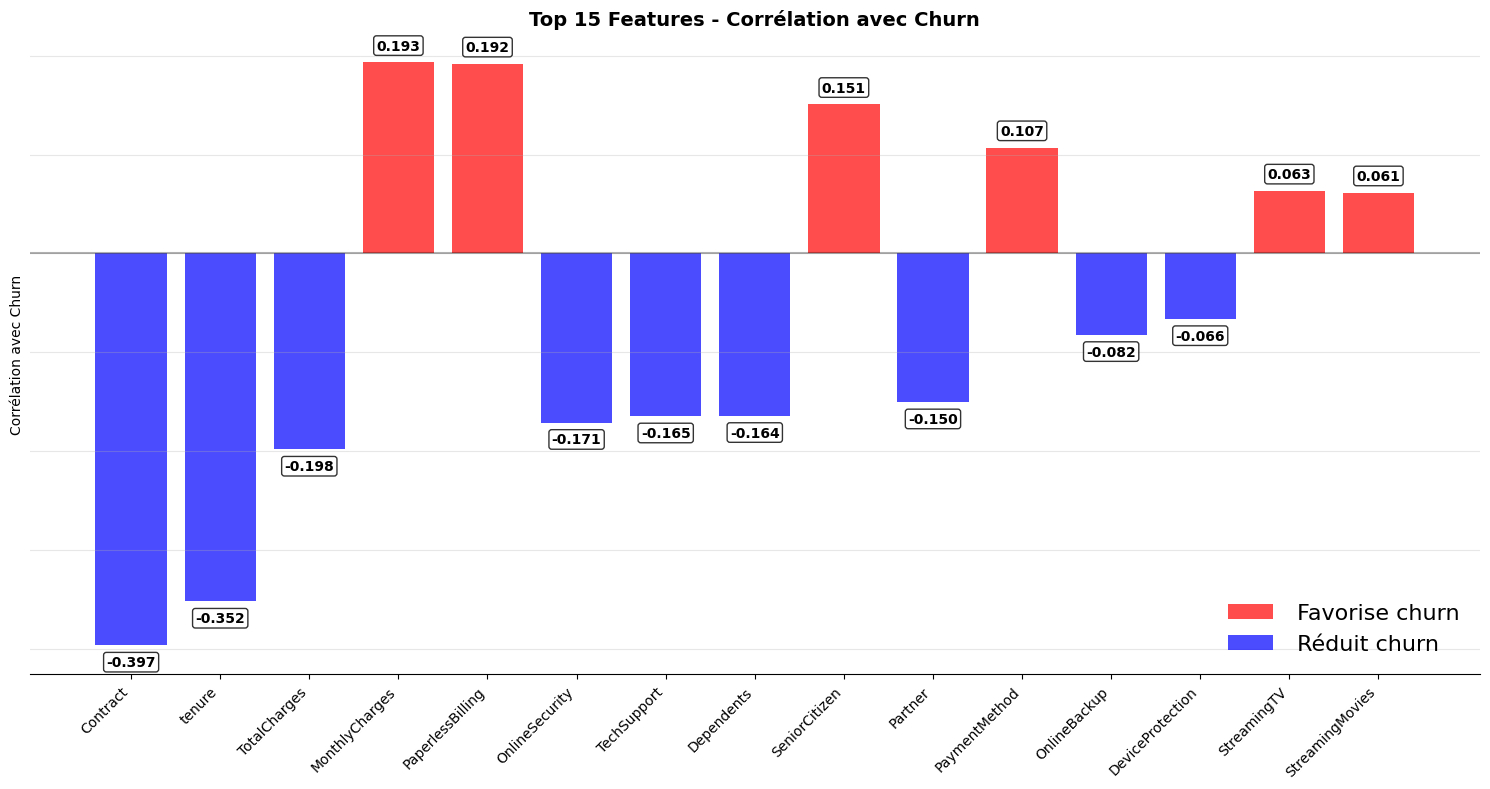

In [24]:
# Heatmap des corrélations pour une vue d'ensemble
plt.figure(figsize=(12, 10))

# Calculer la matrice de corrélation
corr_matrix = DF_encoded[all_features+['Churn']].corr()

# Heatmap focalisée sur Churn
churn_correlations = corr_matrix['Churn'].sort_values(key=abs, ascending=False)

# Créer un histogramme vertical des top corrélations
plt.figure(figsize=(15, 8))  # Élargi pour les labels horizontaux
top_15 = churn_correlations[1:16]  # Exclure Churn lui-même
colors = ['red' if x > 0 else 'blue' for x in top_15]

# Créer les barres VERTICALES
bars = plt.bar(range(len(top_15)), top_15.values, color=colors, alpha=0.7)

# Ajouter les valeurs au-dessus/en-dessous des barres
for i, (bar, value) in enumerate(zip(bars, top_15.values)):
    # Position du texte : au-dessus si positif, en-dessous si négatif
    if value >= 0:
        y_pos = value + 0.01  # Décalage vers le haut
        va = 'bottom'
    else:
        y_pos = value - 0.01  # Décalage vers le bas
        va = 'top'
    
    # Afficher la valeur avec 3 décimales
    plt.text(i, y_pos, f'{value:.3f}', 
             ha='center', va=va, fontweight='bold', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Labels sur l'axe X avec rotation pour lisibilité
plt.xticks(range(len(top_15)), top_15.index, rotation=45, ha='right')
plt.ylabel('Corrélation avec Churn')
plt.title('Top 15 Features - Corrélation avec Churn', fontsize=14, fontweight='bold')

# Ligne horizontale de référence à 0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)

# RETIRER TOUS LES BORDS SAUF L'AXE X (bottom)
ax = plt.gca()
ax.spines['top'].set_visible(False)      # Retirer bord du haut
ax.spines['right'].set_visible(False)    # Retirer bord de droite  
ax.spines['left'].set_visible(False)     # Retirer bord de gauche
ax.spines['bottom'].set_visible(True)    # Garder seulement l'axe X
ax.tick_params(left=False, labelleft=False)  # Retirer les ticks et labels Y
# AJOUTER LA LÉGENDE AVEC LES COULEURS

legend_elements = [
    Patch(facecolor='red', alpha=0.7, label=' Favorise churn'),
    Patch(facecolor='blue', alpha=0.7, label=' Réduit churn')
]
plt.legend(handles=legend_elements, loc='lower right', frameon=False, fontsize=16)

# Ajuster les marges pour que les labels soient visibles
plt.subplots_adjust(bottom=0.25, top=0.9)
plt.tight_layout()
plt.show()

On constate que les 5 features les plus importantes sont le type de Contrat, l'ancienneté, TotalCharges, Monthly Charges et PaperlessBilling

On peut envisager un peu de feature engineering afin de créer de nouvelles features

In [25]:
print("=== ANALYSE SEGMENTS TENURE ===")

# Créer des segments d'ancienneté
DF_encoded['tenure_segment'] = pd.cut(DF_encoded['tenure'], 
                                    bins=[-1, 6, 12, 24, 100], # Ici on commence à -1 afin d'intégrer les clients qui ont 0mois d'ancienneté
                                    labels=['Nouveaux_0-6m', 'Junior_6-12m', 'Moyen_12-24m', 'Senior_24m+'])

# Taux de churn par segment
churn_by_tenure = DF_encoded.groupby('tenure_segment')['Churn'].agg(['count', 'sum', 'mean']).round(3)
churn_by_tenure['churn_rate'] = churn_by_tenure['mean']
print("Taux de churn par ancienneté:")
print(churn_by_tenure)


=== ANALYSE SEGMENTS TENURE ===
Taux de churn par ancienneté:
                count  sum   mean  churn_rate
tenure_segment                               
Nouveaux_0-6m    1481  784  0.529       0.529
Junior_6-12m      705  253  0.359       0.359
Moyen_12-24m     1024  294  0.287       0.287
Senior_24m+      3833  538  0.140       0.140


C:\Users\lenovo\AppData\Local\Temp\ipykernel_12416\1332844068.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = DF_encoded.groupby('tenure_segment')['Churn'].agg(['count', 'sum', 'mean']).round(3)


On constate que plus l'ancienneté augmente et plus le taux de churn diminue

In [26]:

# Focus sur les nouveaux clients (plus critiques)
nouveaux_clients = DF_encoded[DF_encoded['tenure'] <= 12]
print(f"\nClients ≤ 12 mois: {len(nouveaux_clients)} ({len(nouveaux_clients)/len(DF_encoded)*100:.1f}%)")
print(f"Taux churn nouveaux: {nouveaux_clients['Churn'].mean():.3f}")


Clients ≤ 12 mois: 2186 (31.0%)
Taux churn nouveaux: 0.474


## Feature Engineering

On va créer de nouvelles variables :

- Ratio_MonthlyCharges_tenure : Ratio entre l'abonnement par mois et l'ancienneté
- Ratio_TotalCharges_MonthlyCharges*tenure : Vérifier si le Total charges renseigné est en accord avec le total calculé
- is_new_customer : Le client est il présent depuis moins de 6 mois ou non

In [27]:
# Créer des indicateurs de risque
DF_encoded['Ratio_MonthlyCharges_tenure'] = DF_encoded['MonthlyCharges'] / (DF_encoded['tenure'] + 1)
DF_encoded['Ratio_TotalCharges_MonthlyCharges*tenure'] = DF_encoded['TotalCharges'] / (DF_encoded['MonthlyCharges'] * DF_encoded['tenure'])
DF_encoded['is_new_customer'] = (DF_encoded['tenure'] <= 6).astype(int)

In [28]:
DF_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   customerID                                7043 non-null   object  
 1   gender                                    7043 non-null   int64   
 2   SeniorCitizen                             7043 non-null   int64   
 3   Partner                                   7043 non-null   int64   
 4   Dependents                                7043 non-null   int64   
 5   tenure                                    7043 non-null   int64   
 6   PhoneService                              7043 non-null   int64   
 7   MultipleLines                             7043 non-null   int64   
 8   InternetService                           7043 non-null   int64   
 9   OnlineSecurity                            7043 non-null   int64   
 10  OnlineBackup            

On constate que la feature créée 'total_vs_expected' contient des Nan

In [29]:
DF_encoded.loc[DF_encoded['Ratio_TotalCharges_MonthlyCharges*tenure'].isna(),['TotalCharges','MonthlyCharges','tenure']]

,TotalCharges,MonthlyCharges,tenure
488,0.0,52.55,0
753,0.0,20.25,0
936,0.0,80.85,0
1082,0.0,25.75,0
1340,0.0,56.05,0
3331,0.0,19.85,0
3826,0.0,25.35,0
4380,0.0,20.00,0
5218,0.0,19.70,0
6670,0.0,73.35,0


Les NaN sont dûs à une division de 0 par 0 dans la formule de calcul, il nous suffit donc de remplacer les Nan par la valeur 1 car le ration total vs monthly * tenure est de 1.

In [30]:
DF_encoded['Ratio_TotalCharges_MonthlyCharges*tenure']=DF_encoded[['Ratio_TotalCharges_MonthlyCharges*tenure']].fillna(1)

Il nous faut maintenant encoder la feature 'tenure_segment' qui est de type 'category'

On va créer notre propre label encoder pour la variable 'tenure_segment'

In [31]:
print("=== ENCODAGE PERSONNALISÉ TENURE_SEGMENT ===")

# Ton dictionnaire d'encodage
tenure_segment_encoder = {
    'Nouveaux_0-6m': 0,
    'Junior_6-12m': 1,
    'Moyen_12-24m': 2,
    'Senior_24m+': 3
}

# Appliquer l'encodage avec .map()
DF_encoded['tenure_segment_encoded'] = DF_encoded['tenure_segment'].map(tenure_segment_encoder)
DF_encoded['tenure_segment_encoded'] = DF_encoded['tenure_segment_encoded'].astype('int')
# Vérification
print("Vérification de l'encodage:")
print(DF_encoded[['tenure_segment', 'tenure_segment_encoded']].drop_duplicates().sort_values('tenure_segment_encoded'))

print(f"\nValeurs uniques avant: {DF_encoded['tenure_segment'].unique()}")
print(f"Valeurs uniques après: {DF_encoded['tenure_segment_encoded'].unique()}")

# Vérifier qu'il n'y a pas de valeurs manquantes (NaN)
if DF_encoded['tenure_segment_encoded'].isna().any():
    print("⚠️ Attention: Des valeurs n'ont pas été encodées!")
    print("Valeurs non mappées:", DF_encoded[DF_encoded['tenure_segment_encoded'].isna()]['tenure_segment'].unique())
else:
    print("✅ Tous les segments ont été encodés avec succès")

=== ENCODAGE PERSONNALISÉ TENURE_SEGMENT ===
Vérification de l'encodage:
  tenure_segment  tenure_segment_encoded
0  Nouveaux_0-6m                       0
5   Junior_6-12m                       1
6   Moyen_12-24m                       2
1    Senior_24m+                       3

Valeurs uniques avant: ['Nouveaux_0-6m', 'Senior_24m+', 'Junior_6-12m', 'Moyen_12-24m']
Categories (4, object): ['Nouveaux_0-6m' < 'Junior_6-12m' < 'Moyen_12-24m' < 'Senior_24m+']
Valeurs uniques après: [0 3 1 2]
✅ Tous les segments ont été encodés avec succès


Sauvegardons notre encoder pour une utilisation future

In [32]:
# Sauvegarder ton encoder personnalisé

# Sauvegarde en JSON (plus lisible que pickle pour un dict simple)
with open('encoders_churn/tenure_segment_encoder.json', 'w') as f:
    json.dump(tenure_segment_encoder, f, indent=2)

print("✅ Encoder personnalisé sauvegardé: encoders_churn/tenure_segment_encoder.json")

# Pour charger plus tard:
# with open('encoders_churn/tenure_segment_encoder.json', 'r') as f:
#     loaded_encoder = json.load(f)

✅ Encoder personnalisé sauvegardé: encoders_churn/tenure_segment_encoder.json


On va maintenant retirer les ID des clients ainsi que tenure_segment

In [33]:
DF_encoded_no_Id = DF_encoded.drop(['customerID', 'tenure_segment'], axis = 1)

In [34]:
DF_encoded_no_Id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   gender                                    7043 non-null   int64  
 1   SeniorCitizen                             7043 non-null   int64  
 2   Partner                                   7043 non-null   int64  
 3   Dependents                                7043 non-null   int64  
 4   tenure                                    7043 non-null   int64  
 5   PhoneService                              7043 non-null   int64  
 6   MultipleLines                             7043 non-null   int64  
 7   InternetService                           7043 non-null   int64  
 8   OnlineSecurity                            7043 non-null   int64  
 9   OnlineBackup                              7043 non-null   int64  
 10  DeviceProtection                    

Maintenant voyons si nos nouvelles features ont un impact important

In [35]:
all_features = DF_encoded_no_Id.columns.tolist()

<Figure size 1200x1000 with 0 Axes>

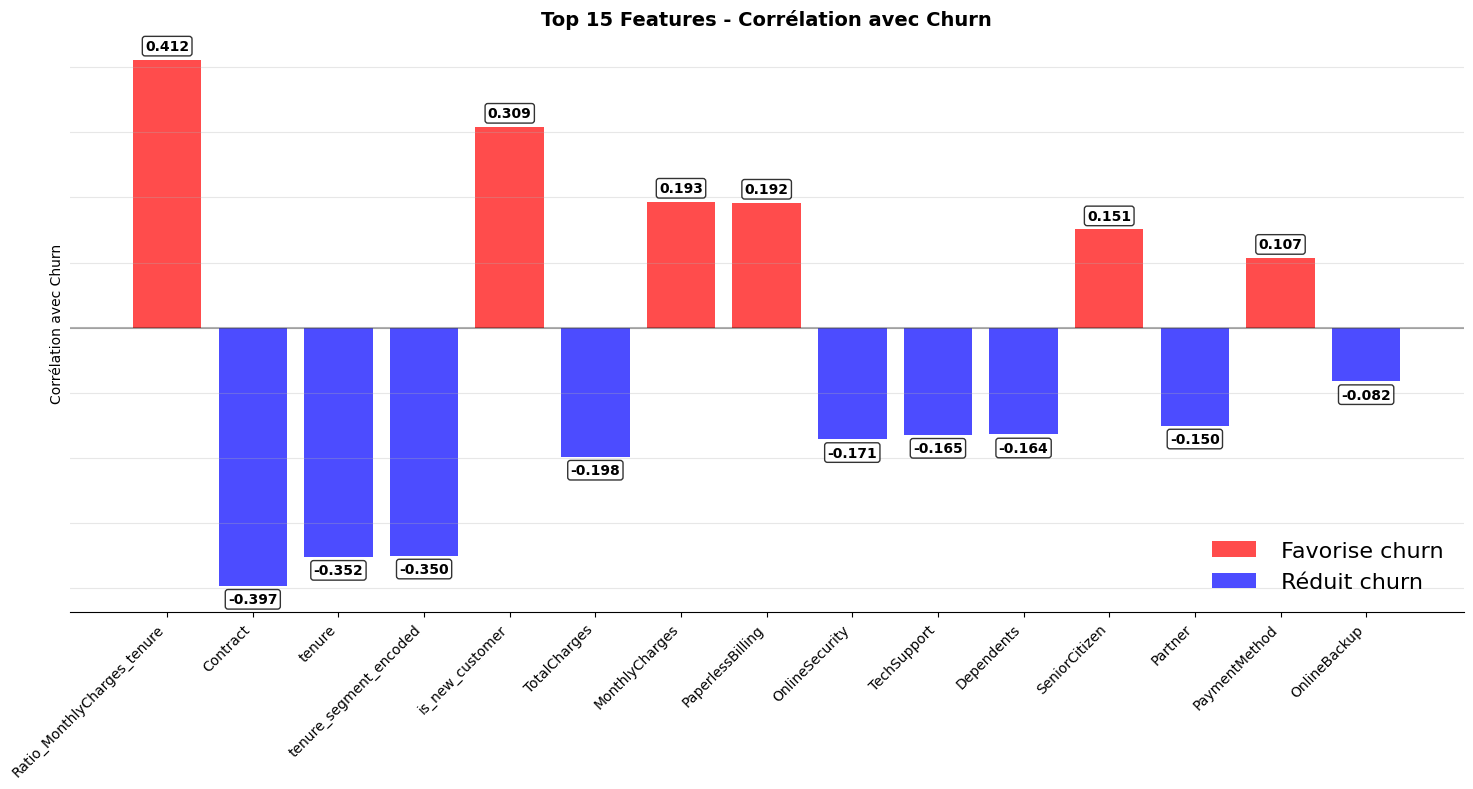

In [36]:
# Heatmap des corrélations pour une vue d'ensemble
plt.figure(figsize=(12, 10))

# Calculer la matrice de corrélation
corr_matrix = DF_encoded_no_Id[all_features].corr()

# Heatmap focalisée sur Churn
churn_correlations = corr_matrix['Churn'].sort_values(key=abs, ascending=False)

# Créer un histogramme vertical des top corrélations
plt.figure(figsize=(15, 8))  # Élargi pour les labels horizontaux
top_15 = churn_correlations[1:16]  # Exclure Churn lui-même
colors = ['red' if x > 0 else 'blue' for x in top_15]

# Créer les barres VERTICALES
bars = plt.bar(range(len(top_15)), top_15.values, color=colors, alpha=0.7)

# Ajouter les valeurs au-dessus/en-dessous des barres
for i, (bar, value) in enumerate(zip(bars, top_15.values)):
    # Position du texte : au-dessus si positif, en-dessous si négatif
    if value >= 0:
        y_pos = value + 0.01  # Décalage vers le haut
        va = 'bottom'
    else:
        y_pos = value - 0.01  # Décalage vers le bas
        va = 'top'
    
    # Afficher la valeur avec 3 décimales
    plt.text(i, y_pos, f'{value:.3f}', 
             ha='center', va=va, fontweight='bold', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Labels sur l'axe X avec rotation pour lisibilité
plt.xticks(range(len(top_15)), top_15.index, rotation=45, ha='right')
plt.ylabel('Corrélation avec Churn')
plt.title('Top 15 Features - Corrélation avec Churn', fontsize=14, fontweight='bold')

# Ligne horizontale de référence à 0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='y', alpha=0.3)

# RETIRER TOUS LES BORDS SAUF L'AXE X (bottom)
ax = plt.gca()
ax.spines['top'].set_visible(False)      # Retirer bord du haut
ax.spines['right'].set_visible(False)    # Retirer bord de droite  
ax.spines['left'].set_visible(False)     # Retirer bord de gauche
ax.spines['bottom'].set_visible(True)    # Garder seulement l'axe X
ax.tick_params(left=False, labelleft=False)  # Retirer les ticks et labels Y
# AJOUTER LA LÉGENDE AVEC LES COULEURS
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label=' Favorise churn'),
    Patch(facecolor='blue', alpha=0.7, label=' Réduit churn')
]
plt.legend(handles=legend_elements, loc='lower right', frameon=False, fontsize=16)

# Ajuster les marges pour que les labels soient visibles
plt.subplots_adjust(bottom=0.25, top=0.9)
plt.tight_layout()
plt.show()

Parfait trois de nos nouvelles features ont un lien de corrélation important avec la target

Nous allons utiliser simplement les 5 meilleures features qui sont 'Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'tenure_segment_encoded', 'is_new_customer'

On va donc utiliser ce Dataframe pour notre étude, on va le nommer DF_modèle

In [37]:
DF_modèle = DF_encoded_no_Id.copy()

# Mise en place des modéles de ML avec tracking Mlflow

In [38]:
print("=== SETUP MLFLOW + SCORE BUSINESS ===")

# Configuration MLflow
mlflow.set_experiment("Churn_Prediction_Telecoms")
mlflow.set_tracking_uri("./mlruns")  # Dossier local pour les logs



# Créer un scorer pour sklearn
business_scorer = make_scorer(business_score, greater_is_better=True)

print("✅ MLflow configuré")
print("✅ Score business créé : Profit = (TP*4 - FP*2.5 - FN*5) / Total")

=== SETUP MLFLOW + SCORE BUSINESS ===
✅ MLflow configuré
✅ Score business créé : Profit = (TP*4 - FP*2.5 - FN*5) / Total


In [39]:

X = DF_modèle.drop(['Churn'], axis=1).copy()
y = DF_modèle['Churn']


In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   gender                                    7043 non-null   int64  
 1   SeniorCitizen                             7043 non-null   int64  
 2   Partner                                   7043 non-null   int64  
 3   Dependents                                7043 non-null   int64  
 4   tenure                                    7043 non-null   int64  
 5   PhoneService                              7043 non-null   int64  
 6   MultipleLines                             7043 non-null   int64  
 7   InternetService                           7043 non-null   int64  
 8   OnlineSecurity                            7043 non-null   int64  
 9   OnlineBackup                              7043 non-null   int64  
 10  DeviceProtection                    

In [41]:

# Split train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Données préparées : {X.shape} | Features: {X.columns.tolist()}")

✅ Données préparées : (7043, 23) | Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Ratio_MonthlyCharges_tenure', 'Ratio_TotalCharges_MonthlyCharges*tenure', 'is_new_customer', 'tenure_segment_encoded']


In [42]:
print("=== ENTRAÎNEMENT DES 3 MODÈLES AVEC MLFLOW ===")

# Stockage des résultats
results = {}

# 1. LOGISTIC REGRESSION
print("\n🔄 Entraînement Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=2000,
    solver='liblinear'
)

lr_scaler = StandardScaler()
lr_params = {
    'class_weight': 'balanced',
    'max_iter': 2000,
    'solver': 'liblinear',
    'features_used': len(X.columns),
    'total_samples': len(X)
}

results['Logistic_Regression'] = train_and_log_model(
    model=lr_model,
    model_name="Logistic_Regression", 
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=lr_scaler,
    hyperparams=lr_params
)


=== ENTRAÎNEMENT DES 3 MODÈLES AVEC MLFLOW ===

🔄 Entraînement Logistic Regression...
🔄 Entraînement Logistic_Regression avec CV 3-fold...
📊 Cross-validation en cours...
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...
📊 Résultats CV:
  • Business Score: 0.148 ± 0.016
  • Recall: 0.856 ± 0.015
  • Seuil moyen CV: 0.443 ± 0.026
  • AUC: 0.848 ± 0.007
🎯 Entraînement final sur dataset complet...
⚖️ Optimisation du seuil pour business score...
🎯 SEUIL OPTIMAL TROUVÉ: 0.3081
✅ Seuil dans une plage raisonnable
📊 ANALYSE DU SEUIL 0.3081:
  • 792 clients prédits churn (56.2%)
  • 617 clients prédits fidèles (43.8%)


2025/07/06 09:02:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 09:02:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logistic_Regression - Recall: 0.928 | Precision: 0.438 | Business Score: 0.100
   CV Business Score: 0.148 ± 0.016
   Seuil final: 0.3081


In [43]:

# 2. XGBOOST
print("\n🔄 Entraînement XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='logloss'
)

xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': len(y_train[y_train==0])/len(y_train[y_train==1]),
    'features_used': len(X.columns),
    'total_samples': len(X)
}

results['XGBoost'] = train_and_log_model(
    model=xgb_model,
    model_name="XGBoost",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=None,  # Pas de scaling pour XGBoost
    hyperparams=xgb_params
)



🔄 Entraînement XGBoost...
🔄 Entraînement XGBoost avec CV 3-fold...
📊 Cross-validation en cours...
  Fold 1/3...
  Fold 2/3...
  Fold 3/3...
📊 Résultats CV:
  • Business Score: 0.103 ± 0.037
  • Recall: 0.831 ± 0.051
  • Seuil moyen CV: 0.350 ± 0.090
  • AUC: 0.837 ± 0.008
🎯 Entraînement final sur dataset complet...
⚖️ Optimisation du seuil pour business score...
🎯 SEUIL OPTIMAL TROUVÉ: 0.2626
🟡 Seuil assez bas - stratégie agressive
📊 ANALYSE DU SEUIL 0.2626:
  • 725 clients prédits churn (51.5%)
  • 684 clients prédits fidèles (48.5%)


2025/07/06 09:03:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [09:03:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/06 09:03:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ XGBoost - Recall: 0.885 | Precision: 0.457 | Business Score: 0.088
   CV Business Score: 0.103 ± 0.037
   Seuil final: 0.2626


In [44]:

# 3. LIGHTGBM
print("\n🔄 Entraînement LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

lgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'class_weight': 'balanced',
    'features_used': len(X.columns),
    'total_samples': len(X)
}

results['LightGBM'] = train_and_log_model(
    model=lgb_model,
    model_name="LightGBM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=None,  # Pas de scaling pour LightGBM
    hyperparams=lgb_params
)

print("\n✅ Entraînement terminé pour les 3 modèles")


🔄 Entraînement LightGBM...
🔄 Entraînement LightGBM avec CV 3-fold...
📊 Cross-validation en cours...
  Fold 1/3...


d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2/3...


d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3/3...


d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📊 Résultats CV:
  • Business Score: 0.105 ± 0.045
  • Recall: 0.818 ± 0.016
  • Seuil moyen CV: 0.399 ± 0.025
  • AUC: 0.839 ± 0.007
🎯 Entraînement final sur dataset complet...
⚖️ Optimisation du seuil pour business score...


d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🎯 SEUIL OPTIMAL TROUVÉ: 0.4223
✅ Seuil dans une plage raisonnable
📊 ANALYSE DU SEUIL 0.4223:
  • 598 clients prédits churn (42.4%)
  • 811 clients prédits fidèles (57.6%)


2025/07/06 09:03:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/06 09:03:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LightGBM - Recall: 0.807 | Precision: 0.505 | Business Score: 0.077
   CV Business Score: 0.105 ± 0.045
   Seuil final: 0.4223

✅ Entraînement terminé pour les 3 modèles


# Analyse de l'importance des features pour réduire la dimensionnalité


=== ANALYSE FEATURE IMPORTANCE - XGBoost ===
🔍 TOP 15 FEATURES LES PLUS IMPORTANTES:
                        feature  importance_gain_pct  cumulative_importance
0                      Contract            33.619999              33.619999
1               is_new_customer            17.860001              51.480000
2        tenure_segment_encoded             9.740000              61.220001
3               InternetService             4.110000              65.330002
4               StreamingMovies             3.070000              68.400002
5   Ratio_MonthlyCharges_tenure             2.570000              70.970001
6                MonthlyCharges             2.280000              73.250000
7                  PhoneService             2.160000              75.410004
8              PaperlessBilling             2.090000              77.489998
9                 PaymentMethod             1.980000              79.470001
10                  TechSupport             1.970000              81.449997
11 

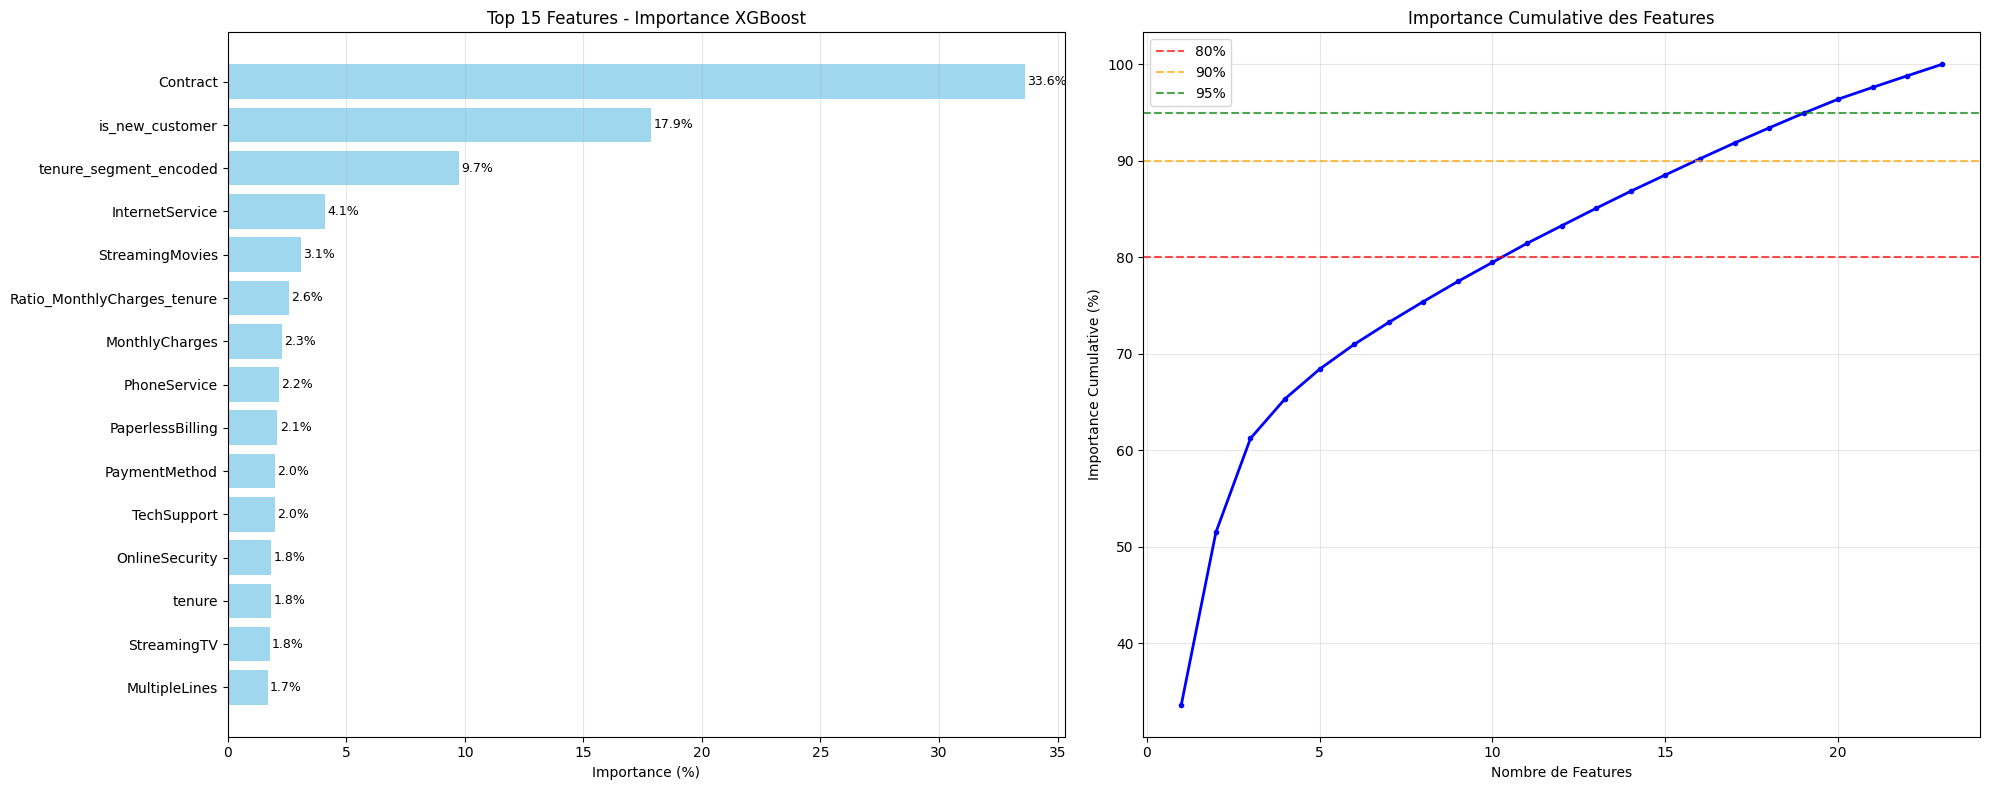

=== ANALYSE DES SEUILS DE CONTRIBUTION ===

🎯 SEUIL 80%:
   • Nombre de features: 11
   • Importance cumulative réelle: 81.4%
   • Top 5 features: ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies']

🎯 SEUIL 85%:
   • Nombre de features: 13
   • Importance cumulative réelle: 85.1%
   • Top 5 features: ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies']

🎯 SEUIL 90%:
   • Nombre de features: 16
   • Importance cumulative réelle: 90.2%
   • Top 5 features: ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies']

🎯 SEUIL 95%:
   • Nombre de features: 20
   • Importance cumulative réelle: 96.4%
   • Top 5 features: ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies']



In [45]:
print("=== ANALYSE FEATURE IMPORTANCE - XGBoost ===")

# Récupérer ton modèle entraîné
trained_xgb_model = results['XGBoost']['model']

def analyze_feature_importance(model, X_train, feature_names=None):
    """
    Analyse complète de l'importance des features avec XGBoost
    """
    if feature_names is None:
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    
    # Extraire les importances (3 méthodes différentes)
    importance_gain = model.feature_importances_  # Par défaut = 'gain'
    
    try:
        importance_weight = model.get_booster().get_score(importance_type='weight')
        importance_cover = model.get_booster().get_score(importance_type='cover')
    except:
        # Fallback si get_booster() ne fonctionne pas
        importance_weight = {f'f{i}': 0 for i in range(len(feature_names))}
        importance_cover = {f'f{i}': 0 for i in range(len(feature_names))}
    
    # Créer DataFrame avec toutes les métriques
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_gain': importance_gain,
        'importance_weight': [importance_weight.get(f'f{i}', 0) for i in range(len(feature_names))],
        'importance_cover': [importance_cover.get(f'f{i}', 0) for i in range(len(feature_names))]
    })
    
    # Normaliser pour avoir des pourcentages
    feature_importance_df['importance_gain_pct'] = (feature_importance_df['importance_gain'] / feature_importance_df['importance_gain'].sum()) * 100
    
    # Trier par importance décroissante
    feature_importance_df = feature_importance_df.sort_values('importance_gain_pct', ascending=False).reset_index(drop=True)
    
    # Calculer l'importance cumulative
    feature_importance_df['cumulative_importance'] = feature_importance_df['importance_gain_pct'].cumsum()
    
    return feature_importance_df

def plot_feature_importance(feature_df, top_n=20):
    """
    Visualisation de l'importance des features
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Graphique 1: Top N features
    top_features = feature_df.head(top_n)
    
    bars = ax1.barh(range(len(top_features)), top_features['importance_gain_pct'], 
                    color='skyblue', alpha=0.8)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance (%)')
    ax1.set_title(f'Top {top_n} Features - Importance XGBoost')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()  # Pour avoir la plus importante en haut
    
    # Ajouter les valeurs sur les barres
    for i, (bar, value) in enumerate(zip(bars, top_features['importance_gain_pct'])):
        ax1.text(value + 0.1, i, f'{value:.1f}%', va='center', fontsize=9)
    
    # Graphique 2: Importance cumulative
    ax2.plot(range(1, len(feature_df) + 1), feature_df['cumulative_importance'], 
             'b-', linewidth=2, marker='o', markersize=3)
    ax2.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80%')
    ax2.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax2.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95%')
    
    ax2.set_xlabel('Nombre de Features')
    ax2.set_ylabel('Importance Cumulative (%)')
    ax2.set_title('Importance Cumulative des Features')
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return fig

def find_optimal_features(feature_df, thresholds=[80, 85, 90, 95]):
    """
    Trouve le nombre optimal de features selon différents seuils
    """
    print("=== ANALYSE DES SEUILS DE CONTRIBUTION ===\n")
    
    results = {}
    
    for threshold in thresholds:
        # Trouver le nombre de features pour atteindre le seuil
        mask = feature_df['cumulative_importance'] <= threshold
        if mask.any():
            n_features = mask.sum() + 1  # +1 pour inclure la feature qui dépasse
        else:
            n_features = 1  # Au minimum 1 feature
        
        n_features = min(n_features, len(feature_df))  # S'assurer qu'on ne dépasse pas
        
        selected_features = feature_df.head(n_features)['feature'].tolist()
        cumulative_imp = feature_df.head(n_features)['cumulative_importance'].iloc[-1]
        
        results[threshold] = {
            'n_features': n_features,
            'features': selected_features,
            'cumulative_importance': cumulative_imp
        }
        
        print(f"🎯 SEUIL {threshold}%:")
        print(f"   • Nombre de features: {n_features}")
        print(f"   • Importance cumulative réelle: {cumulative_imp:.1f}%")
        print(f"   • Top 5 features: {selected_features[:5]}")
        print()
    
    return results

# 1. Analyser l'importance des features avec TON modèle
feature_importance_df = analyze_feature_importance(
    model=trained_xgb_model,
    X_train=X_train,
    feature_names=X_train.columns.tolist()
)

print("🔍 TOP 15 FEATURES LES PLUS IMPORTANTES:")
print(feature_importance_df.head(15)[['feature', 'importance_gain_pct', 'cumulative_importance']].round(2))

# 2. Visualiser
fig = plot_feature_importance(feature_importance_df, top_n=15)

# 3. Trouver les seuils optimaux
optimal_subsets = find_optimal_features(feature_importance_df, thresholds=[80, 85, 90, 95])



In [46]:
print("=== CORRECTION ERREUR MLFLOW - TEST MANUEL ===")

def test_feature_subset_simple(X_train, X_test, y_train, y_test, selected_features, config_name):
    """
    Test simple sans MLflow pour éviter les conflits
    """
    print(f"\n🔄 TEST {config_name}")
    print(f"Features ({len(selected_features)}): {selected_features}")
    
    # Créer les sous-ensembles
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    
    # Entraîner le modèle
    xgb_subset = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        random_state=42,
        eval_metric='logloss'
    )
    
    xgb_subset.fit(X_train_subset, y_train)
    
    # Prédictions
    y_pred_proba = xgb_subset.predict_proba(X_test_subset)[:, 1]
    
    # Optimiser le seuil
    optimal_threshold = optimize_threshold_for_business_score(y_test, y_pred_proba)
    y_pred_final = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Calculer les métriques
    from sklearn.metrics import recall_score, precision_score, confusion_matrix
    
    recall = recall_score(y_test, y_pred_final)
    precision = precision_score(y_test, y_pred_final)
    business_score_value = business_score(y_test, y_pred_final)
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_final)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"🎯 SEUIL OPTIMAL: {optimal_threshold:.4f}")
    print(f"✅ RÉSULTATS {config_name}:")
    print(f"   • Business Score: {business_score_value:.4f}")
    print(f"   • Recall: {recall:.3f}")
    print(f"   • Precision: {precision:.3f}")
    print(f"   • Clients ratés: {fn}")
    
    return {
        'config': config_name,
        'n_features': len(selected_features),
        'business_score': business_score_value,
        'recall': recall,
        'precision': precision,
        'threshold': optimal_threshold,
        'clients_rates': int(fn)
    }

# Définir les configurations
configs_to_test = {
    '10_features_80pct': [
        'Contract', 'is_new_customer', 'tenure_segment_encoded', 
        'InternetService', 'StreamingMovies', 'Ratio_MonthlyCharges_tenure',
        'MonthlyCharges', 'PhoneService', 'PaperlessBilling', 'PaymentMethod'
    ],
    '14_features_90pct': [
        'Contract', 'is_new_customer', 'tenure_segment_encoded', 
        'InternetService', 'StreamingMovies', 'Ratio_MonthlyCharges_tenure',
        'MonthlyCharges', 'PhoneService', 'PaperlessBilling', 'PaymentMethod',
        'TechSupport', 'OnlineSecurity', 'tenure', 'StreamingTV'
    ]
}

# Tester les configurations restantes
results_manual = []

# Ajouter le résultat 8 features déjà obtenu
results_manual.append({
    'config': '8_features_75pct',
    'n_features': 8,
    'business_score': 0.0529,
    'recall': 0.890,
    'precision': 0.442,
    'threshold': 0.2887,
    'clients_rates': 41
})

# Tester les autres configurations
for config_name, features in configs_to_test.items():
    result = test_feature_subset_simple(X_train, X_test, y_train, y_test, features, config_name)
    results_manual.append(result)

# Comparaison finale complète
print("\n" + "="*80)
print("📊 COMPARAISON FINALE COMPLÈTE")
print("="*80)

# Ajouter la référence (toutes features)
all_results = [{
    'config': 'Toutes_features_23',
    'n_features': 23,
    'business_score': 0.0880,
    'recall': 0.885,
    'precision': 0.457,
    'threshold': 0.2626,
    'clients_rates': 43
}] + results_manual

# Créer DataFrame et analyser
df_complete = pd.DataFrame(all_results)

# Calculer performances relatives
baseline_business = df_complete.iloc[0]['business_score']
df_complete['business_relative'] = (df_complete['business_score'] / baseline_business * 100).round(1)

baseline_recall = df_complete.iloc[0]['recall']
df_complete['recall_relative'] = (df_complete['recall'] / baseline_recall * 100).round(1)

# Calculer efficience
df_complete['efficiency'] = (df_complete['business_score'] / df_complete['n_features']).round(6)

print(df_complete[['config', 'n_features', 'business_score', 'business_relative', 
                  'recall', 'recall_relative', 'clients_rates', 'efficiency']].round(4))

# Identifier les configurations optimales
best_business = df_complete.iloc[1:]['business_score'].max()
best_config = df_complete[df_complete['business_score'] == best_business]['config'].iloc[0]

most_efficient = df_complete.iloc[1:]['efficiency'].max()
efficient_config = df_complete[df_complete['efficiency'] == most_efficient]['config'].iloc[0]

print(f"\n🏆 ANALYSE FINALE:")
print(f"• Meilleure performance: {best_config}")
print(f"• Plus efficiente: {efficient_config}")
print(f"• Sweet spot: Configuration avec le meilleur compromis performance/simplicité")

=== CORRECTION ERREUR MLFLOW - TEST MANUEL ===

🔄 TEST 10_features_80pct
Features (10): ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies', 'Ratio_MonthlyCharges_tenure', 'MonthlyCharges', 'PhoneService', 'PaperlessBilling', 'PaymentMethod']
🎯 SEUIL OPTIMAL: 0.3197
✅ RÉSULTATS 10_features_80pct:
   • Business Score: 0.0397
   • Recall: 0.866
   • Precision: 0.450
   • Clients ratés: 50

🔄 TEST 14_features_90pct
Features (14): ['Contract', 'is_new_customer', 'tenure_segment_encoded', 'InternetService', 'StreamingMovies', 'Ratio_MonthlyCharges_tenure', 'MonthlyCharges', 'PhoneService', 'PaperlessBilling', 'PaymentMethod', 'TechSupport', 'OnlineSecurity', 'tenure', 'StreamingTV']
🎯 SEUIL OPTIMAL: 0.2438
✅ RÉSULTATS 14_features_90pct:
   • Business Score: 0.0607
   • Recall: 0.901
   • Precision: 0.439
   • Clients ratés: 37

📊 COMPARAISON FINALE COMPLÈTE
               config  n_features  business_score  business_relative  recall  \
0  Toutes_fe

In [47]:
def analyze_xgboost_all_importance_types(model, feature_names):
    """
    Analyse toutes les métriques d'importance XGBoost
    """
    
    # Extraire toutes les métriques
    importance_gain = model.feature_importances_  # Par défaut
    importance_weight = model.get_booster().get_score(importance_type='weight')
    importance_cover = model.get_booster().get_score(importance_type='cover')
    importance_total_gain = model.get_booster().get_score(importance_type='total_gain')
    
    # Créer DataFrame comparatif
    comparison_df = pd.DataFrame({
        'feature': feature_names,
        'gain': importance_gain,
        'weight': [importance_weight.get(f'f{i}', 0) for i in range(len(feature_names))],
        'cover': [importance_cover.get(f'f{i}', 0) for i in range(len(feature_names))],
        'total_gain': [importance_total_gain.get(f'f{i}', 0) for i in range(len(feature_names))]
    })
    
    # Normaliser chaque métrique
    for col in ['gain', 'weight', 'cover', 'total_gain']:
        comparison_df[f'{col}_pct'] = (comparison_df[col] / comparison_df[col].sum() * 100)
    
    # Calculer score composite
    comparison_df['composite_score'] = (
        comparison_df['gain_pct'] * 0.4 +      # Performance
        comparison_df['weight_pct'] * 0.3 +    # Fréquence usage
        comparison_df['cover_pct'] * 0.3       # Couverture données
    )
    
    return comparison_df.sort_values('composite_score', ascending=False)

In [48]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

def permutation_feature_importance_corrected(model, X_test, y_test):
    """
    Version corrigée de l'importance par permutation
    """
    
    def business_score_for_permutation(y_true, y_pred):
        """
        Scorer adapté pour permutation (reçoit des prédictions, pas des probas)
        """
        return business_score(y_true, y_pred)
    
    # Méthode alternative : calculer manuellement la permutation
    print("🔄 Calcul manuel de permutation importance...")
    
    # Score de référence (sans permutation)
    y_pred_proba_ref = model.predict_proba(X_test)[:, 1]
    optimal_threshold_ref = optimize_threshold_for_business_score(y_test, y_pred_proba_ref)
    y_pred_ref = (y_pred_proba_ref >= optimal_threshold_ref).astype(int)
    reference_score = business_score(y_test, y_pred_ref)
    
    print(f"📊 Score de référence: {reference_score:.4f}")
    
    # Calculer l'importance par permutation manuelle
    permutation_results = []
    
    for i, feature in enumerate(X_test.columns):
        print(f"  Testing {feature}...")
        
        # Créer copie avec feature permutée
        X_test_perm = X_test.copy()
        X_test_perm[feature] = np.random.permutation(X_test_perm[feature].values)
        
        # Prédire avec feature permutée
        y_pred_proba_perm = model.predict_proba(X_test_perm)[:, 1]
        optimal_threshold_perm = optimize_threshold_for_business_score(y_test, y_pred_proba_perm)
        y_pred_perm = (y_pred_proba_perm >= optimal_threshold_perm).astype(int)
        permuted_score = business_score(y_test, y_pred_perm)
        
        # Importance = dégradation de performance
        importance = reference_score - permuted_score
        
        permutation_results.append({
            'feature': feature,
            'reference_score': reference_score,
            'permuted_score': permuted_score,
            'importance': importance,
            'importance_pct': (importance / reference_score * 100) if reference_score != 0 else 0
        })
    
    return pd.DataFrame(permutation_results).sort_values('importance', ascending=False)

def mutual_information_analysis(X_train, y_train):
    """
    Information mutuelle - mesure dépendance non-linéaire
    """
    from sklearn.feature_selection import mutual_info_classif
    
    mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
    
    mi_df = pd.DataFrame({
        'feature': X_train.columns,
        'mutual_info': mi_scores,
        'mi_normalized': mi_scores / mi_scores.max() * 100
    }).sort_values('mutual_info', ascending=False)
    
    return mi_df

def random_forest_importance(X_train, y_train):
    """
    Importance Random Forest pour comparaison
    """
    from sklearn.ensemble import RandomForestClassifier
    
    rf_model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)
    
    rf_df = pd.DataFrame({
        'feature': X_train.columns,
        'rf_importance': rf_model.feature_importances_,
        'rf_normalized': rf_model.feature_importances_ / rf_model.feature_importances_.max() * 100
    }).sort_values('rf_importance', ascending=False)
    
    return rf_df

def correlation_with_target(X_train, y_train):
    """
    Corrélation simple avec la cible
    """
    correlations = []
    for feature in X_train.columns:
        corr = X_train[feature].corr(y_train)
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'correlation_pct': abs(corr) / X_train.corrwith(y_train).abs().max() * 100
        })
    
    return pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)


In [49]:

print("=== ANALYSE MULTI-MÉTHODES FEATURE IMPORTANCE (VERSION CORRIGÉE) ===")

# Utiliser modèle XGBoost déjà entraîné
trained_model = results['XGBoost']['model']

# 1. XGBoost Importance (déjà fait)
print("\n1️⃣ XGBOOST GAIN IMPORTANCE (Déjà calculé)")
print(feature_importance_df[['feature', 'importance_gain_pct', 'cumulative_importance']].head(10).round(2))

# 2. Permutation Importance Corrigée
print("\n2️⃣ PERMUTATION IMPORTANCE (Méthode corrigée)")
perm_results = permutation_feature_importance_corrected(trained_model, X_test, y_test)
print(perm_results[['feature', 'importance', 'importance_pct']].head(10).round(4))

# 3. Random Forest Importance
print("\n3️⃣ RANDOM FOREST IMPORTANCE")
rf_results = random_forest_importance(X_train, y_train)
print(rf_results[['feature', 'rf_normalized']].head(10).round(2))

# 4. Mutual Information
print("\n4️⃣ MUTUAL INFORMATION")
mi_results = mutual_information_analysis(X_train, y_train)
print(mi_results[['feature', 'mi_normalized']].head(10).round(2))

# 5. Corrélation avec cible
print("\n5️⃣ CORRÉLATION AVEC TARGET")
corr_results = correlation_with_target(X_train, y_train)
print(corr_results[['feature', 'correlation_pct']].head(10).round(2))

# 6. CONSENSUS DE TOUTES LES MÉTHODES
print("\n6️⃣ CONSENSUS MULTI-MÉTHODES")

# Merger tous les résultats
consensus_df = pd.DataFrame({'feature': X_train.columns})

# XGBoost
consensus_df = consensus_df.merge(
    feature_importance_df[['feature', 'importance_gain_pct']].rename(columns={'importance_gain_pct': 'xgb_score'}),
    on='feature'
)

# Permutation (normaliser)
perm_normalized = perm_results.copy()
perm_normalized['perm_score'] = (perm_normalized['importance'] / perm_normalized['importance'].max() * 100).fillna(0)
consensus_df = consensus_df.merge(
    perm_normalized[['feature', 'perm_score']], 
    on='feature'
)

# Random Forest
consensus_df = consensus_df.merge(
    rf_results[['feature', 'rf_normalized']].rename(columns={'rf_normalized': 'rf_score'}),
    on='feature'
)

# Mutual Information
consensus_df = consensus_df.merge(
    mi_results[['feature', 'mi_normalized']].rename(columns={'mi_normalized': 'mi_score'}),
    on='feature'
)

# Corrélation
consensus_df = consensus_df.merge(
    corr_results[['feature', 'correlation_pct']].rename(columns={'correlation_pct': 'corr_score'}),
    on='feature'
)

# Score consensus (moyenne pondérée)
consensus_df['consensus_score'] = (
    consensus_df['xgb_score'] * 0.20 +      # XGBoost
    consensus_df['perm_score'] * 0.20 +     # Permutation
    consensus_df['rf_score'] * 0.20 +       # Random Forest
    consensus_df['mi_score'] * 0.20 +       # Mutual Information
    consensus_df['corr_score'] * 0.20       # Corrélation
)

consensus_df = consensus_df.sort_values('consensus_score', ascending=False)

print("🏆 TOP 15 FEATURES - CONSENSUS MULTI-MÉTHODES:")
print(consensus_df[['feature', 'consensus_score', 'xgb_score', 'perm_score', 'rf_score']].head(15).round(2))

# 7. COMPARAISON TOP 10 PAR MÉTHODE
print("\n🔍 COMPARAISON TOP 10 PAR MÉTHODE:")
comparison_methods = pd.DataFrame({
    'Rank': range(1, 16),
    'XGBoost': feature_importance_df.head(15)['feature'].tolist(),
    'Permutation': perm_results.head(15)['feature'].tolist(),
    'RandomForest': rf_results.head(15)['feature'].tolist(),
    'MutualInfo': mi_results.head(15)['feature'].tolist(),
    'Consensus': consensus_df.head(15)['feature'].tolist()
})
print(comparison_methods)

# 8. STABILITÉ DES TOP FEATURES
print("\n📊 STABILITÉ DES TOP FEATURES:")
top_features_all_methods = set()
for col in ['XGBoost', 'Permutation', 'RandomForest', 'MutualInfo', 'Consensus']:
    top_features_all_methods.update(comparison_methods[col].head(15).tolist())

stability_analysis = []
for feature in top_features_all_methods:
    ranks = []
    for col in ['XGBoost', 'Permutation', 'RandomForest', 'MutualInfo', 'Consensus']:
        try:
            rank = comparison_methods[comparison_methods[col] == feature].index[0] + 1
            ranks.append(rank)
        except:
            ranks.append(999)  # Pas dans le top 10
    
    avg_rank = np.mean([r for r in ranks if r <= 15])
    appearances = sum([1 for r in ranks if r <= 15])
    
    stability_analysis.append({
        'feature': feature,
        'avg_rank': avg_rank if not np.isnan(avg_rank) else 999,
        'appearances_top10': appearances,
        'stability_score': appearances * (16 - avg_rank) if not np.isnan(avg_rank) else 0
    })

stability_df = pd.DataFrame(stability_analysis).sort_values('stability_score', ascending=False)
print(stability_df.head(15))

print(f"\n🎯 FEATURES LES PLUS STABLES (dans plusieurs top 10):")
stable_features = stability_df[stability_df['appearances_top10'] >= 3].head(15)['feature'].tolist()
print(stable_features)

=== ANALYSE MULTI-MÉTHODES FEATURE IMPORTANCE (VERSION CORRIGÉE) ===

1️⃣ XGBOOST GAIN IMPORTANCE (Déjà calculé)
                       feature  importance_gain_pct  cumulative_importance
0                     Contract            33.619999              33.619999
1              is_new_customer            17.860001              51.480000
2       tenure_segment_encoded             9.740000              61.220001
3              InternetService             4.110000              65.330002
4              StreamingMovies             3.070000              68.400002
5  Ratio_MonthlyCharges_tenure             2.570000              70.970001
6               MonthlyCharges             2.280000              73.250000
7                 PhoneService             2.160000              75.410004
8             PaperlessBilling             2.090000              77.489998
9                PaymentMethod             1.980000              79.470001

2️⃣ PERMUTATION IMPORTANCE (Méthode corrigée)
🔄 Calcul manuel

In [50]:
print("=== TEST STRATÉGIE 3 MODÈLES CONSENSUS ===")

# Configurations basées sur consensus poids égaux
model_configs = {
    'Simple_5_features': [
        'Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 
        'MonthlyCharges', 'tenure_segment_encoded'
    ],
    'Balanced_10_features': [
        'Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 
        'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 
        'PaymentMethod', 'InternetService', 'PaperlessBilling'
    ],
    'Performance_15_features': [
        'Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges',
        'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 
        'PaymentMethod', 'InternetService', 'PaperlessBilling',
        'Ratio_TotalCharges_MonthlyCharges*tenure', 'OnlineSecurity', 
        'Dependents', 'TechSupport', 'Partner'
    ]
}

# Test des 3 configurations
results_3_models = []

for config_name, features in model_configs.items():
    print(f"\n🔄 TEST {config_name}")
    print(f"Features ({len(features)}): {features[:3]}...")
    
    result = test_feature_subset_simple(
        X_train, X_test, y_train, y_test, 
        features, config_name
    )
    
    results_3_models.append(result)

# Comparaison finale
comparison_3_models = pd.DataFrame(results_3_models)

# Ajouter référence baseline
baseline_ref = {
    'config': 'Baseline_23_features', 
    'n_features': 23, 
    'business_score': 0.0880, 
    'recall': 0.885, 
    'precision': 0.457, 
    'threshold': 0.2626, 
    'clients_rates': 43
}

all_models = [baseline_ref] + results_3_models
final_comparison = pd.DataFrame(all_models)

# Calculs des métriques
final_comparison['business_relative'] = (final_comparison['business_score'] / baseline_ref['business_score'] * 100).round(1)
final_comparison['efficiency'] = (final_comparison['business_score'] / final_comparison['n_features']).round(6)
final_comparison['clients_saved'] = baseline_ref['clients_rates'] - final_comparison['clients_rates']

print("\n" + "="*80)
print("📊 COMPARAISON STRATÉGIE 3 MODÈLES")
print("="*80)

print(final_comparison[['config', 'n_features', 'business_score', 'business_relative', 
                       'recall', 'precision', 'clients_rates', 'clients_saved', 
                       'efficiency']].round(4))

print(f"\n🎯 ANALYSE PROGRESSIVE :")
for i, result in enumerate(results_3_models):
    improvement = ((result['business_score'] / baseline_ref['business_score'] - 1) * 100)
    complexity_reduction = ((baseline_ref['n_features'] - result['n_features']) / baseline_ref['n_features'] * 100)
    
    print(f"📈 {result['config']}:")
    print(f"   • Performance: {improvement:+.1f}% vs baseline")
    print(f"   • Complexité: -{complexity_reduction:.1f}% features")
    print(f"   • Efficience: {result['business_score']/result['n_features']:.6f}")

# Identifier le sweet spot
best_efficiency = max([r['business_score']/r['n_features'] for r in results_3_models])
sweet_spot = [r for r in results_3_models if r['business_score']/r['n_features'] == best_efficiency][0]

print(f"\n🏆 SWEET SPOT IDENTIFIÉ: {sweet_spot['config']}")
print(f"   • Meilleure efficience: {best_efficiency:.6f}")
print(f"   • Recommandé pour production !")

=== TEST STRATÉGIE 3 MODÈLES CONSENSUS ===

🔄 TEST Simple_5_features
Features (5): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']...

🔄 TEST Simple_5_features
Features (5): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded']
🎯 SEUIL OPTIMAL: 0.3590
✅ RÉSULTATS Simple_5_features:
   • Business Score: 0.0199
   • Recall: 0.848
   • Precision: 0.454
   • Clients ratés: 57

🔄 TEST Balanced_10_features
Features (10): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']...

🔄 TEST Balanced_10_features
Features (10): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod', 'InternetService', 'PaperlessBilling']
🎯 SEUIL OPTIMAL: 0.2455
✅ RÉSULTATS Balanced_10_features:
   • Business Score: 0.0564
   • Recall: 0.904
   • Precision: 0.436
   • Clients ratés: 36

🔄 TEST Performance_15_features
Features (15): ['Ratio_MonthlyCharges_tenure', 'Contract', 

In [51]:
print("=== EXPLORATION FINE ZONE OPTIMALE 8-12 FEATURES ===")

# Features ordonnées selon consensus poids égaux
consensus_features_ordered = [
    'Ratio_MonthlyCharges_tenure',    # #1
    'Contract',                       # #2
    'tenure',                         # #3
    'MonthlyCharges',                 # #4
    'tenure_segment_encoded',         # #5
    'TotalCharges',                   # #6
    'is_new_customer',               # #7
    'PaymentMethod',                 # #8
    'InternetService',               # #9
    'PaperlessBilling',              # #10
    'Ratio_TotalCharges_MonthlyCharges*tenure', # #11
    'OnlineSecurity'                 # #12
]

# Configurations à tester (8 à 12 features)
fine_configs = {
    'Features_8': consensus_features_ordered[:8],
    'Features_9': consensus_features_ordered[:9], 
    'Features_10': consensus_features_ordered[:10],
    'Features_11': consensus_features_ordered[:11],
    'Features_12': consensus_features_ordered[:12]
}

print("🔍 Configurations à tester:")
for config_name, features in fine_configs.items():
    print(f"{config_name}: {len(features)} features")
    print(f"  Top 3: {features[:3]}")
    print(f"  Dernière ajoutée: {features[-1]}")
    print()

# Test de chaque configuration
fine_results = []

for config_name, features in fine_configs.items():
    print(f"\n🔄 TEST {config_name}")
    print(f"Features ({len(features)}): {features}")
    
    result = test_feature_subset_simple(
        X_train, X_test, y_train, y_test, 
        features, config_name
    )
    
    fine_results.append(result)
    
    print(f"✅ {config_name} - Business: {result['business_score']:.4f}, Recall: {result['recall']:.3f}, Seuil: {result['threshold']:.4f}")

print("\n" + "="*90)
print("📊 ANALYSE DÉTAILLÉE ZONE OPTIMALE 8-12 FEATURES")
print("="*90)

# Créer DataFrame avec baseline pour comparaison
baseline_ref = {
    'config': 'Baseline_23', 
    'n_features': 23, 
    'business_score': 0.0880, 
    'recall': 0.885, 
    'precision': 0.457, 
    'threshold': 0.2626, 
    'clients_rates': 43
}

all_fine_results = [baseline_ref] + fine_results
fine_df = pd.DataFrame(all_fine_results)

# Calculer métriques comparatives
fine_df['business_relative'] = (fine_df['business_score'] / baseline_ref['business_score'] * 100).round(1)
fine_df['recall_relative'] = (fine_df['recall'] / baseline_ref['recall'] * 100).round(1)
fine_df['clients_saved'] = baseline_ref['clients_rates'] - fine_df['clients_rates']
fine_df['efficiency'] = (fine_df['business_score'] / fine_df['n_features']).round(6)

# Tableau complet
print("📋 TABLEAU COMPARATIF DÉTAILLÉ:")
print(fine_df[['config', 'n_features', 'business_score', 'business_relative', 
               'recall', 'recall_relative', 'threshold', 'clients_rates', 
               'clients_saved', 'efficiency']].round(4))

# Analyse de l'extremum
print(f"\n🎯 ANALYSE DE L'EXTREMUM:")

# Identifier le pic de performance
fine_only = fine_df.iloc[1:]  # Exclure baseline
best_business_idx = fine_only['business_score'].idxmax()
best_config = fine_only.loc[best_business_idx]

print(f"🏆 MEILLEURE PERFORMANCE:")
print(f"   • Configuration: {best_config['config']}")
print(f"   • Business Score: {best_config['business_score']:.4f}")
print(f"   • Amélioration vs baseline: {best_config['business_relative']:.1f}%")
print(f"   • Recall: {best_config['recall']:.3f}")
print(f"   • Seuil optimal: {best_config['threshold']:.4f}")

# Analyse des gains marginaux
print(f"\n📈 GAINS MARGINAUX PAR FEATURE AJOUTÉE:")
for i in range(1, len(fine_only)):
    current = fine_only.iloc[i]
    previous = fine_only.iloc[i-1]
    
    marginal_gain = current['business_score'] - previous['business_score']
    marginal_clients = previous['clients_rates'] - current['clients_rates']
    
    feature_added = fine_configs[current['config']][-1]  # Dernière feature ajoutée
    
    print(f"   • +{feature_added}:")
    print(f"     Gain business: {marginal_gain:+.4f}")
    print(f"     Clients sauvés: {marginal_clients:+d}")
    print(f"     ROI marginal: {marginal_gain/1:.4f}")

# Analyse des seuils
print(f"\n⚖️ ÉVOLUTION DES SEUILS:")
seuil_evolution = fine_only[['config', 'n_features', 'threshold', 'business_score']].copy()

print(seuil_evolution)

# Corrélation seuil/performance
correlation_seuil_business = fine_only['threshold'].corr(fine_only['business_score'])
print(f"\n📊 Corrélation seuil ↔ business score: {correlation_seuil_business:.3f}")

if correlation_seuil_business < -0.5:
    print("   → Seuils plus bas = meilleures performances (stratégie agressive)")
elif correlation_seuil_business > 0.5:
    print("   → Seuils plus hauts = meilleures performances (stratégie conservatrice)")
else:
    print("   → Pas de corrélation claire seuil ↔ performance")

# Identification du plateau de performance
print(f"\n🎢 ANALYSE DU PLATEAU:")
performance_threshold = best_config['business_score'] * 0.95  # 95% du max

plateau_configs = fine_only[fine_only['business_score'] >= performance_threshold]
print(f"Configurations dans le plateau (≥95% du max):")
for _, config in plateau_configs.iterrows():
    print(f"   • {config['config']}: {config['business_score']:.4f} ({config['business_relative']:.1f}%)")

# Recommandations finales
print(f"\n💡 RECOMMANDATIONS:")

if len(plateau_configs) > 1:
    # Choisir la plus simple du plateau
    simplest_in_plateau = plateau_configs.loc[plateau_configs['n_features'].idxmin()]
    print(f"🎯 OPTIMAL EFFICIENCY: {simplest_in_plateau['config']}")
    print(f"   • Performance quasi-maximale avec minimum de complexité")
    print(f"   • {simplest_in_plateau['n_features']} features vs {best_config['n_features']} pour le max")
else:
    print(f"🎯 OPTIMAL UNIQUE: {best_config['config']}")
    print(f"   • Configuration claire pour performance maximale")

# Point de rendements décroissants
marginal_gains = []
for i in range(1, len(fine_only)):
    current = fine_only.iloc[i]
    previous = fine_only.iloc[i-1]
    marginal_gain = current['business_score'] - previous['business_score']
    marginal_gains.append(marginal_gain)

# Trouver où les gains deviennent négligeables
diminishing_threshold = max(marginal_gains) * 0.1  # 10% du meilleur gain marginal
for i, gain in enumerate(marginal_gains):
    if gain < diminishing_threshold:
        diminishing_point = fine_only.iloc[i+1]
        print(f"📉 RENDEMENTS DÉCROISSANTS à partir de: {diminishing_point['config']}")
        print(f"   • Gain marginal < {diminishing_threshold:.4f}")
        break

print(f"\n🚀 CONFIGURATION FINALE RECOMMANDÉE:")
recommended = simplest_in_plateau if len(plateau_configs) > 1 else best_config
print(f"   • Nom: {recommended['config']}")
print(f"   • Features: {recommended['n_features']}")
print(f"   • Business Score: {recommended['business_score']:.4f}")
print(f"   • Seuil: {recommended['threshold']:.4f}")
print(f"   • Clients sauvés: {recommended['clients_saved']:+d}")

=== EXPLORATION FINE ZONE OPTIMALE 8-12 FEATURES ===
🔍 Configurations à tester:
Features_8: 8 features
  Top 3: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']
  Dernière ajoutée: PaymentMethod

Features_9: 9 features
  Top 3: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']
  Dernière ajoutée: InternetService

Features_10: 10 features
  Top 3: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']
  Dernière ajoutée: PaperlessBilling

Features_11: 11 features
  Top 3: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']
  Dernière ajoutée: Ratio_TotalCharges_MonthlyCharges*tenure

Features_12: 12 features
  Top 3: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure']
  Dernière ajoutée: OnlineSecurity


🔄 TEST Features_8
Features (8): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod']

🔄 TEST Features_8
Features (8): ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'Month

On a donc un modèle qui tourne trés bien avec 11 features :

['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod', 'InternetService', 'PaperlessBilling', 'Ratio_TotalCharges_MonthlyCharges*tenure']

seuil optimal pour ce set up :
SEUIL OPTIMAL: 0.3510

# Optimisation hyperparamétres

In [52]:
# Après ton entraînement des 3 modèles, récupérer le seuil XGBoost
optimal_threshold_reference = recommended['threshold']
print(f"🎯 Seuil de référence pour la grid search: {optimal_threshold_reference:.4f}")

🎯 Seuil de référence pour la grid search: 0.3510


In [53]:
DF_optimisation_hyperparamétres = DF_modèle[consensus_features_ordered[:11]+['Churn']].copy()

In [54]:
X = DF_optimisation_hyperparamétres.drop(['Churn'],axis = 1).copy()
y = DF_optimisation_hyperparamétres['Churn'].copy()

In [55]:

# Split train/test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Données préparées : {X.shape} | Features: {X.columns.tolist()}")

✅ Données préparées : (7043, 11) | Features: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod', 'InternetService', 'PaperlessBilling', 'Ratio_TotalCharges_MonthlyCharges*tenure']


In [56]:
print("=== OPTIMISATION XGBOOST AVEC CROSS-VALIDATION ===")

param_distributions = {
    'n_estimators': [100, 200, 300, 500],      # Focus sur plus d'arbres
    'max_depth': [4, 5, 6, 7],                 # Plus conservateur pour 11 features
    'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],  # Plus fin, focus bas
    'subsample': [0.7, 0.8, 0.9],              # Plus conservateur
    'colsample_bytree': [0.7, 0.8, 0.9],       # Idem
    'reg_alpha': [0, 0.1, 0.3, 0.5],           # Régularisation modérée
    'reg_lambda': [0.5, 1.0, 2.0, 3.0]         # Focus régularisation L2
}

print(f"🔍 Grille d'hyperparamètres définie")


=== OPTIMISATION XGBOOST AVEC CROSS-VALIDATION ===
🔍 Grille d'hyperparamètres définie


In [57]:

# Lancer l'optimisation avec seuil fixe
best_xgb_model, best_params, best_cv_score = optimize_xgboost_with_mlflow(
    X_train, y_train, 
    reference_threshold=optimal_threshold_reference,
    
)

🔄 Recherche avec seuil fixe 0.3510...
Fitting 7 folds for each of 1000 candidates, totalling 7000 fits


d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:44:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/07/06 09:44:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [09:44:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/06 09:45:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Recherche terminée en 2350.44 secondes
🏆 Meilleur score CV: 0.0998
🎯 Meilleurs paramètres: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [58]:
print("\n=== ÉVALUATION DU MODÈLE OPTIMISÉ ===")

# Utiliser le seuil de référence du modèle de base
reference_threshold = optimal_threshold_reference
print(f"🎯 Utilisation du seuil de référence: {reference_threshold:.4f}")

# Entraîner et évaluer le modèle optimisé AVEC SEUIL FIXE
with mlflow.start_run(run_name="XGBoost_Optimized_Final"):
    
    # Log des meilleurs paramètres
    mlflow.log_params(best_params)
    mlflow.log_param("optimization_method", "RandomizedSearchCV")
    mlflow.log_param("cv_score", best_cv_score)
    mlflow.log_param("fixed_threshold", reference_threshold)  # ← AJOUT
    
    # ÉVALUATION MANUELLE avec seuil fixe
    print("🎯 Évaluation avec seuil fixe (pas de recalcul)...")
    
    # Prédictions sur test set
    y_pred_proba_opt = best_xgb_model.predict_proba(X_test)[:, 1]
    y_pred_final_opt = (y_pred_proba_opt >= reference_threshold).astype(int)
    
    # Calcul des métriques
    
    optimal_recall = recall_score(y_test, y_pred_final_opt)
    optimal_precision = precision_score(y_test, y_pred_final_opt)
    f1 = f1_score(y_test, y_pred_final_opt)
    auc = roc_auc_score(y_test, y_pred_proba_opt)
    accuracy = accuracy_score(y_test, y_pred_final_opt)
    business_score_value = business_score(y_test, y_pred_final_opt)
    
    # Matrice de confusion
    cm_opt = confusion_matrix(y_test, y_pred_final_opt)
    tn, fp, fn, tp = cm_opt.ravel()
    
    # Calcul du profit
    profit_total = (tp * 4) - (fp * 2.5) - (fn * 5)  # Utilise tes coûts actuels
    
    # Log des métriques dans MLflow
    mlflow.log_metric("recall", optimal_recall)
    mlflow.log_metric("precision", optimal_precision)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("business_score", business_score_value)
    mlflow.log_metric("threshold_used", reference_threshold)  # ← Seuil utilisé
    
    # Métriques de confusion
    mlflow.log_metric("true_positives", int(tp))
    mlflow.log_metric("true_negatives", int(tn))
    mlflow.log_metric("false_positives", int(fp))
    mlflow.log_metric("false_negatives", int(fn))
    mlflow.log_metric("clients_churn_rates", int(fn))
    mlflow.log_metric("profit_total", float(profit_total))
    
    # Log du modèle
    mlflow.xgboost.log_model(best_xgb_model, "model")
    
    print(f"✅ XGBoost_Optimized - Recall: {optimal_recall:.3f} | Precision: {optimal_precision:.3f} | Business Score: {business_score_value:.3f}")
    print(f"   Seuil utilisé: {reference_threshold:.4f} (fixe)")
    
    # Créer l'objet résultat pour la compatibilité
    optimized_result = {
        'model': best_xgb_model,
        'threshold': reference_threshold,  # ← Seuil fixe utilisé
        'recall': optimal_recall,
        'precision': optimal_precision,
        'business_score': business_score_value,
        'profit_total': profit_total,
        'clients_rates': int(fn)
    }


# Comparaison avec le modèle de base
print("\n📊 COMPARAISON AVANT/APRÈS OPTIMISATION:")
print(f"XGBoost Base     - Business Score: {results['XGBoost']['business_score']:.4f}")
print(f"XGBoost Optimisé - Business Score: {optimized_result['business_score']:.4f}")
print(f"Amélioration: {(optimized_result['business_score'] - results['XGBoost']['business_score']):.4f}")

print(f"\nClients ratés:")
print(f"XGBoost Base     - {results['XGBoost']['clients_rates']} clients")
print(f"XGBoost Optimisé - {optimized_result['clients_rates']} clients")
print(f"Amélioration: {results['XGBoost']['clients_rates'] - optimized_result['clients_rates']} clients sauvés")

# Sauvegarde du meilleur modèle
results['XGBoost_Optimized'] = optimized_result


=== ÉVALUATION DU MODÈLE OPTIMISÉ ===
🎯 Utilisation du seuil de référence: 0.3510
🎯 Évaluation avec seuil fixe (pas de recalcul)...


2025/07/06 09:45:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
d:\projet_gael_pennessot\churn\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [09:45:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/07/06 09:45:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ XGBoost_Optimized - Recall: 0.864 | Precision: 0.462 | Business Score: 0.069
   Seuil utilisé: 0.3510 (fixe)

📊 COMPARAISON AVANT/APRÈS OPTIMISATION:
XGBoost Base     - Business Score: 0.0880
XGBoost Optimisé - Business Score: 0.0688
Amélioration: -0.0192

Clients ratés:
XGBoost Base     - 43 clients
XGBoost Optimisé - 51 clients
Amélioration: -8 clients sauvés


In [59]:
print("\n=== ÉVALUATION ET SAUVEGARDE MODÈLE CHAMPION ===")

# Évaluer le modèle optimisé pour obtenir toutes les métriques
print("📊 Évaluation complète du modèle optimisé...")

# Prédictions avec le modèle optimisé
y_pred_proba_optimized = best_xgb_model.predict_proba(X_test)[:, 1]
y_pred_optimized = (y_pred_proba_optimized >= optimal_threshold_reference).astype(int)

# Calculer toutes les métriques
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

recall_optimized = recall_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
business_score_optimized = business_score(y_test, y_pred_optimized)

# Matrice de confusion
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm_optimized.ravel()

# Calcul du profit
profit_total_optimized = (tp * 4) - (fp * 2.5) - (fn * 5)

# Créer l'objet optimized_result
optimized_result = {
    'model': best_xgb_model,
    'threshold': optimal_threshold_reference,
    'recall': recall_optimized,
    'precision': precision_optimized,
    'f1_score': f1_optimized,
    'auc': auc_optimized,
    'accuracy': accuracy_optimized,
    'business_score': business_score_optimized,
    'profit_total': profit_total_optimized,
    'clients_rates': int(fn),
    'hyperparams': best_params,
    'cv_score': best_cv_score
}

print(f"✅ Métriques calculées:")
print(f"   • Business Score: {business_score_optimized:.4f}")
print(f"   • Recall: {recall_optimized:.3f}")
print(f"   • Precision: {precision_optimized:.3f}")
print(f"   • Clients ratés: {int(fn)}")

print("\n=== SAUVEGARDE MODÈLE CHAMPION ===")

# Créer le dossier de sauvegarde
import os
import joblib
import json

os.makedirs('models_production', exist_ok=True)

# Sauvegarder le modèle optimisé
joblib.dump(best_xgb_model, 'models_production/xgboost_champion_optimized.pkl')
print("✅ Modèle XGBoost sauvegardé")

# Sauvegarder le seuil optimal
joblib.dump(optimal_threshold_reference, 'models_production/optimal_threshold.pkl')
print("✅ Seuil optimal sauvegardé")

# Sauvegarder les hyperparamètres optimisés
with open('models_production/best_hyperparams_optimized.json', 'w') as f:
    json.dump(best_params, f, indent=2)
print("✅ Hyperparamètres optimisés sauvegardés")

# Sauvegarder les features utilisées
features_11_final = [
    'Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges',
    'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 
    'PaymentMethod', 'InternetService', 'PaperlessBilling',
    'Ratio_TotalCharges_MonthlyCharges*tenure'
]

with open('models_production/features_list.json', 'w') as f:
    json.dump(features_11_final, f, indent=2)
print("✅ Liste des 11 features sauvegardée")

# Sauvegarder les métriques finales complètes
final_metrics_optimized = {
    'model_type': 'XGBoost_Optimized_11_Features',
    'optimization_date': str(pd.Timestamp.now()),
    'n_features': len(features_11_final),
    'threshold': float(optimal_threshold_reference),
    'cv_score': float(best_cv_score),
    
    # Métriques de performance
    'recall': float(recall_optimized),
    'precision': float(precision_optimized),
    'f1_score': float(f1_optimized),
    'auc': float(auc_optimized),
    'accuracy': float(accuracy_optimized),
    'business_score': float(business_score_optimized),
    
    # Métriques business
    'profit_total': float(profit_total_optimized),
    'clients_rates': int(fn),
    'profit_per_client': float(profit_total_optimized / len(y_test)),
    
    # Confusion matrix
    'true_positives': int(tp),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    
    # Features utilisées
    'features_used': features_11_final,
    
    # Hyperparamètres
    'best_hyperparams': best_params,
    
    # Comparaison avec baseline
    'baseline_business_score': 0.0880,
    'performance_vs_baseline': float(business_score_optimized / 0.0880 * 100),
    'features_reduction': f"{(23 - len(features_11_final))/23*100:.1f}%"
}

with open('models_production/final_metrics_optimized.json', 'w') as f:
    json.dump(final_metrics_optimized, f, indent=2)
print("✅ Métriques complètes sauvegardées")

# Sauvegarder un résumé executive
summary_executive = {
    'MODEL_CHAMPION': 'XGBoost 11 Features Optimized',
    'PERFORMANCE': f"{final_metrics_optimized['performance_vs_baseline']:.1f}% du baseline",
    'SIMPLIFICATION': final_metrics_optimized['features_reduction'],
    'BUSINESS_SCORE': final_metrics_optimized['business_score'],
    'RECALL': final_metrics_optimized['recall'],
    'CLIENTS_RATES': final_metrics_optimized['clients_rates'],
    'READY_FOR_PRODUCTION': True,
    'DEPLOYMENT_DATE': str(pd.Timestamp.now().date())
}

with open('models_production/EXECUTIVE_SUMMARY.json', 'w') as f:
    json.dump(summary_executive, f, indent=2)

print("\n" + "="*60)
print("🏆 MODÈLE CHAMPION FINALISÉ ET SAUVEGARDÉ")
print("="*60)

print(f"📁 Fichiers sauvegardés dans 'models_production/':")
print(f"   • xgboost_champion_optimized.pkl")
print(f"   • optimal_threshold.pkl")
print(f"   • best_hyperparams_optimized.json")
print(f"   • features_list.json")
print(f"   • final_metrics_optimized.json")
print(f"   • EXECUTIVE_SUMMARY.json")

print(f"\n📊 RÉSUMÉ PERFORMANCE:")
print(f"   • Business Score: {business_score_optimized:.4f}")
print(f"   • Performance vs baseline: {business_score_optimized/0.0880*100:.1f}%")
print(f"   • Recall: {recall_optimized:.1%} (✅ >80%)")
print(f"   • Precision: {precision_optimized:.1%}")
print(f"   • Clients ratés: {int(fn)}")
print(f"   • Features: {len(features_11_final)} (vs 23 baseline)")
print(f"   • Réduction complexité: {(23-len(features_11_final))/23*100:.1f}%")

print(f"\n🚀 MODÈLE PRÊT POUR DÉPLOIEMENT PRODUCTION!")


=== ÉVALUATION ET SAUVEGARDE MODÈLE CHAMPION ===
📊 Évaluation complète du modèle optimisé...
✅ Métriques calculées:
   • Business Score: 0.0688
   • Recall: 0.864
   • Precision: 0.462
   • Clients ratés: 51

=== SAUVEGARDE MODÈLE CHAMPION ===
✅ Modèle XGBoost sauvegardé
✅ Seuil optimal sauvegardé
✅ Hyperparamètres optimisés sauvegardés
✅ Liste des 11 features sauvegardée
✅ Métriques complètes sauvegardées

🏆 MODÈLE CHAMPION FINALISÉ ET SAUVEGARDÉ
📁 Fichiers sauvegardés dans 'models_production/':
   • xgboost_champion_optimized.pkl
   • optimal_threshold.pkl
   • best_hyperparams_optimized.json
   • features_list.json
   • final_metrics_optimized.json
   • EXECUTIVE_SUMMARY.json

📊 RÉSUMÉ PERFORMANCE:
   • Business Score: 0.0688
   • Performance vs baseline: 78.2%
   • Recall: 86.4% (✅ >80%)
   • Precision: 46.2%
   • Clients ratés: 51
   • Features: 11 (vs 23 baseline)
   • Réduction complexité: 52.2%

🚀 MODÈLE PRÊT POUR DÉPLOIEMENT PRODUCTION!


# Test du modéle sur un nouveau dataframe

In [60]:
path = r'D:\projet_gael_pennessot\churn\telco.csv'

In [61]:
DF = pd.read_csv(path)

In [62]:
DF.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges


In [63]:
DF.shape

(7043, 50)

In [64]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [65]:
DF_IBM= DF[['Monthly Charge', 'Total Charges', 'Churn Label', 'Tenure in Months', 'Contract', 'Payment Method', 'Internet Service', 'Paperless Billing']].copy()

In [66]:
DF_IBM['Total Charges']

0         39.65
1        633.30
2       1752.55
3       2514.50
4       2868.15
         ...   
7038    1419.40
7039    1990.50
7040    7362.90
7041     346.45
7042    6844.50
Name: Total Charges, Length: 7043, dtype: float64

In [67]:
DF_IBM['MonthlyCharges']=DF_IBM['Monthly Charge']
DF_IBM['tenure'] = DF_IBM['Tenure in Months']
DF_IBM['TotalCharges'] = DF_IBM['Total Charges']
DF_IBM['Churn'] = DF_IBM['Churn Label']
DF_IBM['PaymentMethod'] = DF_IBM['Payment Method']
DF_IBM['InternetService'] = DF_IBM['Internet Service']
DF_IBM['PaperlessBilling'] = DF_IBM['Paperless Billing']

In [68]:
DF_IBM=DF_IBM.drop(['Monthly Charge', 'Tenure in Months', 'Total Charges', 'Churn Label', 'Total Charges', 'Payment Method', 'Internet Service', 'Paperless Billing'], axis =1).copy()

In [69]:
DF_IBM.head()

,Contract,MonthlyCharges,tenure,TotalCharges,Churn,PaymentMethod,InternetService,PaperlessBilling
0,Month-to-Month,39.65,1,39.65,Yes,Bank Withdrawal,Yes,Yes
1,Month-to-Month,80.65,8,633.30,Yes,Credit Card,Yes,Yes
2,Month-to-Month,95.45,18,1752.55,Yes,Bank Withdrawal,Yes,Yes
3,Month-to-Month,98.50,25,2514.50,Yes,Bank Withdrawal,Yes,Yes
4,Month-to-Month,76.50,37,2868.15,Yes,Bank Withdrawal,Yes,Yes


In [70]:
DF_IBM['Contract'].unique()

array(['Month-to-Month', 'One Year', 'Two Year'], dtype=object)

PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

In [71]:
DF_IBM['PaymentMethod'].unique()

array(['Bank Withdrawal', 'Credit Card', 'Mailed Check'], dtype=object)

In [72]:
print("=== ENCODAGE PERSONNALISÉ TENURE_SEGMENT ===")

# Ton dictionnaire d'encodage
Contract_replace = {
    'Month-to-Month': 'Month-to-month',
    'One Year': 'One year',
    'Two Year': 'Two year'
    }

PaymentMethod_replace = {
    'Bank Withdrawal' : 'Bank transfer (automatic)',
    'Credit Card' : 'Credit card (automatic)',
    'Mailed Check' : 'Mailed check'

}

# Appliquer les remplacements avec .map()
DF_IBM['Contract'] = DF_IBM['Contract'].map(Contract_replace)
DF_IBM['PaymentMethod'] = DF_IBM['PaymentMethod'].map(PaymentMethod_replace)

=== ENCODAGE PERSONNALISÉ TENURE_SEGMENT ===


In [73]:
DF_IBM['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [74]:
DF_IBM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Contract          7043 non-null   object 
 1   MonthlyCharges    7043 non-null   float64
 2   tenure            7043 non-null   int64  
 3   TotalCharges      7043 non-null   float64
 4   Churn             7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   PaperlessBilling  7043 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB


In [75]:
# Répartition realistic basée sur les proportions originales
DF_IBM_realistic = DF_IBM.copy()
yes_mask_realistic = DF_IBM_realistic['InternetService'] == 'Yes'
n_yes_realistic = yes_mask_realistic.sum()

# Attribution selon proportions réelles
realistic_assignment = np.random.choice(
    ['DSL', 'Fiber optic'], 
    size=n_yes_realistic,
    p=[dsl_prop, fiber_prop]  # Proportions réalistes
)

DF_IBM_realistic.loc[yes_mask_realistic, 'InternetService'] = realistic_assignment

print(f"\n✅ RÉPARTITION RÉALISTE APPLIQUÉE:")
print(DF_IBM_realistic['InternetService'].value_counts())



✅ RÉPARTITION RÉALISTE APPLIQUÉE:
InternetService
Fiber optic    3080
DSL            2437
No             1526
Name: count, dtype: int64


In [76]:
DF_IBM['InternetService'] = DF_IBM_realistic['InternetService']

In [77]:
print("=== RÉUTILISATION DES ENCODERS SAUVEGARDÉS ===")



# Chemin vers tes encoders
encoders_dir = 'encoders_churn'

# Encoder Contract avec l'encoder existant
if os.path.exists(f"{encoders_dir}/labelencoder_Contract.pkl"):
    with open(f"{encoders_dir}/labelencoder_Contract.pkl", 'rb') as f:
        contract_encoder = pickle.load(f)
    
    # Vérifier si toutes les valeurs sont dans l'encoder
    print(f"Valeurs Contract dans nouvelles données: {DF_IBM['Contract'].unique()}")
    print(f"Valeurs dans encoder existant: {contract_encoder.classes_}")
    
    # Encoder
    DF_IBM['Contract'] = contract_encoder.transform(DF_IBM['Contract'])
    print("✅ Contract encodé avec encoder existant")
else:
    print("⚠️ Encoder Contract non trouvé")
    

if os.path.exists(f"{encoders_dir}/labelencoder_PaymentMethod.pkl"):
    with open(f"{encoders_dir}/labelencoder_PaymentMethod.pkl", 'rb') as f:
        PaymentMethod_encoder = pickle.load(f)
    
    # Vérifier si toutes les valeurs sont dans l'encoder
    print(f"Valeurs Contract dans nouvelles données: {DF_IBM['PaymentMethod'].unique()}")
    print(f"Valeurs dans encoder existant: {PaymentMethod_encoder.classes_}")
    
    # Encoder
    DF_IBM['PaymentMethod'] = PaymentMethod_encoder.transform(DF_IBM['PaymentMethod'])
    print("✅ PaymentMethod encodé avec encoder existant")
else:
    print("⚠️ Encoder PaymentMethod non trouvé")

if os.path.exists(f"{encoders_dir}/labelencoder_PaperlessBilling.pkl"):
    with open(f"{encoders_dir}/labelencoder_PaperlessBilling.pkl", 'rb') as f:
        PaperlessBilling_encoder = pickle.load(f)
    
    # Vérifier si toutes les valeurs sont dans l'encoder
    print(f"Valeurs Contract dans nouvelles données: {DF_IBM['PaperlessBilling'].unique()}")
    print(f"Valeurs dans encoder existant: {PaperlessBilling_encoder.classes_}")
    
    # Encoder
    DF_IBM['PaperlessBilling'] = PaperlessBilling_encoder.transform(DF_IBM['PaperlessBilling'])
    print("✅ PaperlessBilling encodé avec encoder existant")
else:
    print("⚠️ Encoder PaperlessBilling non trouvé")

if os.path.exists(f"{encoders_dir}/labelencoder_InternetService.pkl"):
    with open(f"{encoders_dir}/labelencoder_InternetService.pkl", 'rb') as f:
        InternetService_encoder = pickle.load(f)
    
    # Vérifier si toutes les valeurs sont dans l'encoder
    print(f"Valeurs Contract dans nouvelles données: {DF_IBM['InternetService'].unique()}")
    print(f"Valeurs dans encoder existant: {InternetService_encoder.classes_}")
    
    # Encoder
    DF_IBM['InternetService'] = InternetService_encoder.transform(DF_IBM['InternetService'])
    print("✅ InternetService encodé avec encoder existant")
else:
    print("⚠️ Encoder InternetService non trouvé")

# Encoder Churn
if 'Churn' in DF_IBM.columns and DF_IBM['Churn'].dtype == 'object':
    print(f"Valeurs Churn avant encodage: {DF_IBM['Churn'].unique()}")
    
    # Mapping manuel pour Churn (plus sûr)
    churn_mapping = {'No': 0, 'Yes': 1}
    DF_IBM['Churn'] = DF_IBM['Churn'].map(churn_mapping)
    print("✅ Churn encodé")

print(f"\nShape après encodage: {DF_IBM.shape}")
print(f"Types de données:\n{DF_IBM.dtypes}")

=== RÉUTILISATION DES ENCODERS SAUVEGARDÉS ===
Valeurs Contract dans nouvelles données: ['Month-to-month' 'One year' 'Two year']
Valeurs dans encoder existant: ['Month-to-month' 'One year' 'Two year']
✅ Contract encodé avec encoder existant
Valeurs Contract dans nouvelles données: ['Bank transfer (automatic)' 'Credit card (automatic)' 'Mailed check']
Valeurs dans encoder existant: ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
✅ PaymentMethod encodé avec encoder existant
Valeurs Contract dans nouvelles données: ['Yes' 'No']
Valeurs dans encoder existant: ['No' 'Yes']
✅ PaperlessBilling encodé avec encoder existant
Valeurs Contract dans nouvelles données: ['Fiber optic' 'DSL' 'No']
Valeurs dans encoder existant: ['DSL' 'Fiber optic' 'No']
✅ InternetService encodé avec encoder existant
Valeurs Churn avant encodage: ['Yes' 'No']
✅ Churn encodé

Shape après encodage: (7043, 8)
Types de données:
Contract              int64
MonthlyCharges      floa

In [78]:
print("\n=== CRÉATION DES FEATURES ENGINEERED ===")

# Feature 1: Segments tenure (même logique que avant)
DF_IBM['tenure_segment'] = pd.cut(DF_IBM['tenure'], 
                             bins=[0, 6, 12, 24, 100], 
                             labels=['Nouveaux_0-6m', 'Junior_6-12m', 'Moyen_12-24m', 'Senior_24m+'])

# Feature 2: Encoder tenure_segment avec ton encoder personnalisé
tenure_segment_encoder = {
    'Nouveaux_0-6m': 0,
    'Junior_6-12m': 1,
    'Moyen_12-24m': 2,
    'Senior_24m+': 3
}

DF_IBM['tenure_segment_encoded'] = DF_IBM['tenure_segment'].map(tenure_segment_encoder)

# Feature 3: Ratio MonthlyCharges/tenure 
DF_IBM['Ratio_MonthlyCharges_tenure'] = DF_IBM['MonthlyCharges'] / (DF_IBM['tenure'] + 1)
DF_IBM['Ratio_TotalCharges_MonthlyCharges*tenure'] = DF_IBM['TotalCharges'] / (DF_IBM['MonthlyCharges'] * DF_IBM['tenure'])
# Feature 4: Is new customer
DF_IBM['is_new_customer'] = (DF_IBM['tenure'] <= 6).astype(int)

print("✅ Features engineered créées")
print(f"Nouvelles colonnes: {DF_IBM.columns.tolist()}")


=== CRÉATION DES FEATURES ENGINEERED ===
✅ Features engineered créées
Nouvelles colonnes: ['Contract', 'MonthlyCharges', 'tenure', 'TotalCharges', 'Churn', 'PaymentMethod', 'InternetService', 'PaperlessBilling', 'tenure_segment', 'tenure_segment_encoded', 'Ratio_MonthlyCharges_tenure', 'Ratio_TotalCharges_MonthlyCharges*tenure', 'is_new_customer']


In [79]:
print("\n=== VALIDATION DES DONNÉES ===")

# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne:")
print(DF_IBM.isnull().sum())

# Vérifier les types
print(f"\nTypes de données finaux:")
print(DF_IBM.dtypes)

# Statistiques descriptives
print(f"\nStatistiques descriptives:")
print(DF_IBM.describe())

# Distribution de la target
print(f"\nDistribution Churn:")
print(DF_IBM['Churn'].value_counts())
print(f"Taux de churn: {DF_IBM['Churn'].mean():.3f}")

# Vérifier les encodages
print(f"\nVérification encodages:")
print(f"Contract values: {DF_IBM['Contract'].unique()}")
print(f"tenure_segment_encoded values: {DF_IBM['tenure_segment_encoded'].unique()}")
print(f"is_new_customer values: {DF_IBM['is_new_customer'].unique()}")


=== VALIDATION DES DONNÉES ===
Valeurs manquantes par colonne:
Contract                                    0
MonthlyCharges                              0
tenure                                      0
TotalCharges                                0
Churn                                       0
PaymentMethod                               0
InternetService                             0
PaperlessBilling                            0
tenure_segment                              0
tenure_segment_encoded                      0
Ratio_MonthlyCharges_tenure                 0
Ratio_TotalCharges_MonthlyCharges*tenure    0
is_new_customer                             0
dtype: int64

Types de données finaux:
Contract                                       int64
MonthlyCharges                               float64
tenure                                         int64
TotalCharges                                 float64
Churn                                          int64
PaymentMethod                     

In [80]:
top_11_features = ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod', 'InternetService', 'PaperlessBilling', 'Ratio_TotalCharges_MonthlyCharges*tenure']

In [81]:
print("\n=== PRÉPARATION FEATURES FINALES ===")



# Créer le dataset final
DF_final = DF_IBM[top_11_features+['Churn']].copy()
DF_final['tenure_segment_encoded'] = DF_final['tenure_segment_encoded'].astype('int')
print(f"Dataset final shape: {DF_final.shape}")
print(f"Features finales: {DF_final.columns.tolist()}")

# Vérifier qu'on a toutes les données
print(f"\nVérification finale:")
print(f"• Tous les encodages OK: ")
print(f" {DF_final.dtypes} ")
print(f"• Pas de valeurs manquantes: {DF_final.isnull().sum().sum() == 0}")
print(f"• Distribution Churn: {DF_final['Churn'].value_counts().to_dict()}")

# Sauvegarder le dataset traité
DF_final.to_csv('DF_IBM_processed.csv', index=False)
print("✅ Dataset IBM traité sauvegardé")


=== PRÉPARATION FEATURES FINALES ===
Dataset final shape: (7043, 12)
Features finales: ['Ratio_MonthlyCharges_tenure', 'Contract', 'tenure', 'MonthlyCharges', 'tenure_segment_encoded', 'TotalCharges', 'is_new_customer', 'PaymentMethod', 'InternetService', 'PaperlessBilling', 'Ratio_TotalCharges_MonthlyCharges*tenure', 'Churn']

Vérification finale:
• Tous les encodages OK: 
 Ratio_MonthlyCharges_tenure                 float64
Contract                                      int64
tenure                                        int64
MonthlyCharges                              float64
tenure_segment_encoded                        int64
TotalCharges                                float64
is_new_customer                               int64
PaymentMethod                                 int64
InternetService                               int64
PaperlessBilling                              int64
Ratio_TotalCharges_MonthlyCharges*tenure    float64
Churn                                         int

In [82]:
print("\n=== COMPARAISON STATISTIQUE DÉTAILLÉE ===")

# Créer un dataset de comparaison avec les mêmes colonnes
# Adapter les noms si nécessaire
colonnes_comparaison = {
    'tenure': 'tenure',
    'Contract': 'Contract',
    'is_new_customer': 'is_new_customer'
}

differences_trouvees = []

for col_ibm, col_orig in colonnes_comparaison.items():
    if col_orig in DF_modèle.columns:
        # Comparer les statistiques
        stats_ibm = DF_final[col_ibm].describe()
        stats_orig = DF_modèle[col_orig].describe()
        
        print(f"\n📊 {col_ibm}:")
        print(f"IBM:      {stats_ibm.to_dict()}")
        print(f"Original: {stats_orig.to_dict()}")
        
        # Test d'égalité
        if col_ibm == 'tenure' and col_orig == 'tenure':
            # Comparaison directe pour tenure
            sont_identiques = (DF_final[col_ibm] == DF_modèle[col_orig]).all()
            print(f"Valeurs identiques: {sont_identiques}")
            if not sont_identiques:
                differences_trouvees.append(col_ibm)
        
        # Comparaison des distributions
        dist_ibm = DF_final[col_ibm].value_counts().sort_index()
        dist_orig = DF_modèle[col_orig].value_counts().sort_index()
        
        print(f"Distribution IBM: {dist_ibm.to_dict()}")
        print(f"Distribution Original: {dist_orig.to_dict()}")
        
        if not dist_ibm.equals(dist_orig):
            differences_trouvees.append(f"{col_ibm}_distribution")

print(f"\n🔍 Différences trouvées: {differences_trouvees}")


=== COMPARAISON STATISTIQUE DÉTAILLÉE ===

📊 tenure:
IBM:      {'count': 7043.0, 'mean': 32.38676700269772, 'std': 24.542061011425535, 'min': 1.0, '25%': 9.0, '50%': 29.0, '75%': 55.0, 'max': 72.0}
Original: {'count': 7043.0, 'mean': 32.37114865824223, 'std': 24.55948102309446, 'min': 0.0, '25%': 9.0, '50%': 29.0, '75%': 55.0, 'max': 72.0}
Valeurs identiques: False
Distribution IBM: {1: 613, 2: 238, 3: 200, 4: 176, 5: 133, 6: 110, 7: 131, 8: 123, 9: 119, 10: 127, 11: 99, 12: 117, 13: 109, 14: 76, 15: 99, 16: 80, 17: 87, 18: 97, 19: 73, 20: 71, 21: 63, 22: 90, 23: 85, 24: 94, 25: 79, 26: 79, 27: 72, 28: 57, 29: 72, 30: 72, 31: 65, 32: 69, 33: 64, 34: 65, 35: 88, 36: 50, 37: 65, 38: 59, 39: 56, 40: 64, 41: 70, 42: 65, 43: 65, 44: 51, 45: 61, 46: 74, 47: 68, 48: 64, 49: 66, 50: 68, 51: 68, 52: 80, 53: 70, 54: 68, 55: 64, 56: 80, 57: 65, 58: 67, 59: 60, 60: 76, 61: 76, 62: 70, 63: 72, 64: 80, 65: 76, 66: 89, 67: 98, 68: 100, 69: 95, 70: 119, 71: 170, 72: 362}
Distribution Original: {0: 11

In [83]:
print("=== TEST DE ROBUSTESSE CROSS-DATASET ===")



# Charger le modèle champion et ses paramètres
model_champion = joblib.load('models_production/xgboost_champion_optimized.pkl')
threshold_optimal = joblib.load('models_production/optimal_threshold.pkl')

# Charger les métriques de référence
with open('models_production/final_metrics.json', 'r') as f:
    metrics_reference = json.load(f)

print(f"📊 MODÈLE DE RÉFÉRENCE (Dataset Kaggle):")
print(f"• Recall: {metrics_reference['recall']:.3f}")
print(f"• Precision: {metrics_reference['precision']:.3f}")
print(f"• Business Score: {metrics_reference['business_score']:.3f}")
print(f"• Seuil optimal: {metrics_reference['threshold']:.3f}")
print(f"• Clients ratés: {metrics_reference['clients_rates']}")

# Préparer les données IBM
X_IBM = DF_final[top_11_features]
y_IBM = DF_final['Churn']

print(f"\n🔍 TEST SUR DATASET IBM:")
print(f"• Taille: {X_IBM.shape}")
print(f"• Distribution Churn: {y_IBM.value_counts().to_dict()}")
print(f"• Taux de churn: {y_IBM.mean():.3f}")

# Prédictions avec le modèle champion ET le seuil optimal existant
y_pred_proba_IBM = model_champion.predict_proba(X_IBM)[:, 1]
y_pred_IBM = (y_pred_proba_IBM >= threshold_optimal).astype(int)

# Calcul des métriques 
recall_IBM = recall_score(y_IBM, y_pred_IBM)
precision_IBM = precision_score(y_IBM, y_pred_IBM)
f1_IBM = f1_score(y_IBM, y_pred_IBM)
auc_IBM = roc_auc_score(y_IBM, y_pred_proba_IBM)
accuracy_IBM = accuracy_score(y_IBM, y_pred_IBM)
business_score_IBM = business_score(y_IBM, y_pred_IBM)

# Matrice de confusion
cm_IBM = confusion_matrix(y_IBM, y_pred_IBM)
tn, fp, fn, tp = cm_IBM.ravel()

print(f"\n📈 RÉSULTATS SUR DATASET IBM:")
print(f"• Recall: {recall_IBM:.3f}")
print(f"• Precision: {precision_IBM:.3f}")
print(f"• F1-Score: {f1_IBM:.3f}")
print(f"• AUC: {auc_IBM:.3f}")
print(f"• Accuracy: {accuracy_IBM:.3f}")
print(f"• Business Score: {business_score_IBM:.3f}")

print(f"\n📊 MATRICE DE CONFUSION IBM:")
print(f"[[TN: {tn}, FP: {fp}]")
print(f" [FN: {fn}, TP: {tp}]]")
print(f"Clients churn ratés: {fn}")

# Calcul du profit total
profit_IBM = (tp * 4) - (fp * 1) - (fn * 5)
print(f"Profit total IBM: {profit_IBM}")

=== TEST DE ROBUSTESSE CROSS-DATASET ===
📊 MODÈLE DE RÉFÉRENCE (Dataset Kaggle):
• Recall: 0.829
• Precision: 0.459
• Business Score: 0.005
• Seuil optimal: 0.436
• Clients ratés: 64

🔍 TEST SUR DATASET IBM:
• Taille: (7043, 11)
• Distribution Churn: {0: 5174, 1: 1869}
• Taux de churn: 0.265

📈 RÉSULTATS SUR DATASET IBM:
• Recall: 0.884
• Precision: 0.543
• F1-Score: 0.673
• AUC: 0.889
• Accuracy: 0.772
• Business Score: 0.290

📊 MATRICE DE CONFUSION IBM:
[[TN: 3782, FP: 1392]
 [FN: 217, TP: 1652]]
Clients churn ratés: 217
Profit total IBM: 4131
